Importing all packages and requirements

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import re
import math
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


INPUT_PATH  = "/mnt/data/data.csv"   # change if needed
OUTPUT_PATH = "/mnt/data/cleaned_data.csv"

Column Mapping & Ranges

In [21]:
# Canonical column names (lowercased + stripped)
CANONICAL = {
    "timestamp": "timestamp",
    "vehicle gps latitude": "lat",
    "vehicle gps longitude": "lon",
    "fuel consumption rate": "fuel_lph",
    "eta variation (hours)": "eta_var_h",
    "traffic congestion level": "congestion_0_10",
    "warehouse inventory level": "inventory_units",
    "loading/unloading time": "load_unload_h",
    "handling equipment availability": "equip_avail",
    "order fulfillment status": "on_time_flag",
    "weather condition severity": "weather_0_1",
    "port congestion level": "port_cong_0_10",
    "shipping costs": "ship_cost_usd",
    "supplier reliability score": "supplier_rel_0_1",
    "lead time (days)": "lead_time_d",
    "historical demand": "hist_demand_units",
    "iot temperature": "iot_temp_c",
    "cargo condition status": "cargo_ok_flag",
    "route risk level": "route_risk_0_10",
    "customs clearance time": "customs_time",
    "driver behavior score": "driver_beh_0_1",
    "fatigue monitoring score": "fatigue_0_1",
    "disruption likelihood score": "disrupt_0_1",
    "delay probability": "delay_prob_0_1",
    "risk classification": "risk_class",
    "delivery time deviation": "deliv_dev_h"
}

# Expected ranges for clipping
RANGES = {
    "lat": (-90.0, 90.0),
    "lon": (-180.0, 180.0),
    "congestion_0_10": (0, 10),
    "port_cong_0_10": (0, 10),
    "route_risk_0_10": (0, 10),
    "weather_0_1": (0, 1),
    "supplier_rel_0_1": (0, 1),
    "driver_beh_0_1": (0, 1),
    "fatigue_0_1": (0, 1),
    "on_time_flag": (0, 1),
    "cargo_ok_flag": (0, 1)
}

BINARY_COLS = ["equip_avail", "on_time_flag", "cargo_ok_flag"]
CATEGORICAL_COLS = ["risk_class"]
IQR_CAP_COLS = [
    "fuel_lph","eta_var_h","load_unload_h","ship_cost_usd",
    "lead_time_d","hist_demand_units","iot_temp_c",
    "customs_time","deliv_dev_h"
]

Helper Functions and Load/Normalise Headers

In [22]:
def normalise_headers(columns):
    normed = []
    for c in columns:
        key = c.strip().lower()
        normed.append(CANONICAL.get(key, c.strip()))
    return normed

def coerce_binary(df, col):
    if col not in df: return
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(0).clip(0, 1).astype(int)

def clip_to_ranges(df):
    for col, (lo, hi) in RANGES.items():
        if col in df:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df[col] = df[col].clip(lower=lo, upper=hi)

def iqr_cap(df, col):
    if col not in df: return
    if not np.issubdtype(df[col].dtype, np.number):
        df[col] = pd.to_numeric(df[col], errors="coerce")
    s = df[col].dropna()
    if s.empty: return
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0: return
    lo = max(q1 - 1.5 * iqr, s.min())
    hi = q3 + 1.5 * iqr
    df[col] = df[col].clip(lower=lo, upper=hi)
    
df = pd.read_csv("data.csv")
df.columns = normalise_headers(df.columns)
print("Shape:", df.shape)
df.head()

df = pd.read_csv("data.csv")
df.columns = normalise_headers(df.columns)
print("Shape:", df.shape)
df.head()

if "timestamp" in df:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    df = df[~df["timestamp"].isna()]
    df = df.sort_values("timestamp")
    df = df.drop_duplicates(subset=["timestamp"] + [c for c in ["lat","lon"] if c in df])

print("After timestamp cleaning:", df.shape)


# Convert numerics
for c in df.columns:
    if c not in ["timestamp"] + CATEGORICAL_COLS:
        df[c] = pd.to_numeric(df[c], errors="ignore")

# Fix binary cols
for col in BINARY_COLS:
    if col in df:
        coerce_binary(df, col)

# Fill missing values
for c in df.columns:
    if c == "timestamp": 
        continue
    if c in CATEGORICAL_COLS:
        mode_val = df[c].mode(dropna=True)
        if not mode_val.empty:
            df[c] = df[c].fillna(mode_val.iloc[0])
    elif np.issubdtype(df[c].dtype, np.number):
        med = df[c].median(skipna=True)
        if pd.notna(med):
            df[c] = df[c].fillna(med)


# Clip ranges
clip_to_ranges(df)

# Drop invalid lat/lon
if "lat" in df and "lon" in df:
    df = df[(df["lat"].between(-90, 90)) & (df["lon"].between(-180, 180))]

# Outlier capping
for col in IQR_CAP_COLS:
    iqr_cap(df, col)

print("After cleaning:", df.shape)



OUTPUT_PATH = "cleaned_data.csv"


df.to_csv(OUTPUT_PATH, index=False)
print(f"Cleaned dataset saved to: {OUTPUT_PATH}")
df.info()
df.head()


Shape: (32065, 26)
Shape: (32065, 26)
After timestamp cleaning: (32065, 26)
After cleaning: (32065, 26)
Cleaned dataset saved to: cleaned_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   timestamp                        32065 non-null  datetime64[ns, UTC]
 1   vehicle_gps_latitude             32065 non-null  float64            
 2   vehicle_gps_longitude            32065 non-null  float64            
 3   fuel_consumption_rate            32065 non-null  float64            
 4   eta_variation_hours              32065 non-null  float64            
 5   traffic_congestion_level         32065 non-null  float64            
 6   warehouse_inventory_level        32065 non-null  float64            
 7   loading_unloading_time           32065 non-null  float64            
 8  

timestamp  vehicle_gps_latitude  vehicle_gps_longitude  \
0 2021-01-01 00:00:00+00:00             40.375568             -77.014318   
1 2021-01-01 01:00:00+00:00             33.507818            -117.036902   
2 2021-01-01 02:00:00+00:00             30.020640             -75.269224   
3 2021-01-01 03:00:00+00:00             36.649223             -70.190529   
4 2021-01-01 04:00:00+00:00             30.001279             -70.012195   

   fuel_consumption_rate  eta_variation_hours  traffic_congestion_level  \
0               5.136512             4.998009                  5.927586   
1               5.101512             0.984929                  1.591992   
2               5.090803             4.972665                  8.787765   
3               8.219558             3.095064                  0.045257   
4               5.000075             3.216077                  8.004851   

   warehouse_inventory_level  loading_unloading_time  \
0                 985.716862                4.951392   
1                 396.700206                1.030379   
2                 832.408935                4.220229   
3                   0.573283                0.530186   
4                 914.925067                3.620890   

   handling_equipment_availability  order_fulfillment_status  ...  \
0                         0.481294                  0.761166  ...   
1                         0.620780                  0.196594  ...   
2                         0.810933                  0.152742  ...   
3                         0.008525                  0.811885  ...   
4                         0.020083                  0.053659  ...   

   iot_temperature  cargo_condition_status  route_risk_level  \
0         0.574400                0.777263          1.182116   
1        -9.753493                0.091839          9.611988   
2        -6.491034                0.253529          6.570431   
3        -0.151276                0.877576          0.548952   
4         2.429448                0.262081          8.861443   

   customs_clearance_time  driver_behavior_score  fatigue_monitoring_score  \
0                0.502006               0.033843                  0.978599   
1                0.966774               0.201725                  0.918586   
2                0.945627               0.264045                  0.394215   
3                4.674035               0.362885                  0.905444   
4                3.445429               0.016957                  0.258702   

   disruption_likelihood_score  delay_probability  risk_classification  \
0                     0.506152           0.885291        Moderate Risk   
1                     0.980784           0.544178            High Risk   
2                     0.998633           0.803322            High Risk   
3                     0.993320           0.025977            High Risk   
4                     0.912433           0.991122            High Risk   

   delivery_time_deviation  
0                 9.110682  
1                 8.175281  
2                 1.283594  
3                 9.304897  
4                 7.752484  

[5 rows x 26 columns]

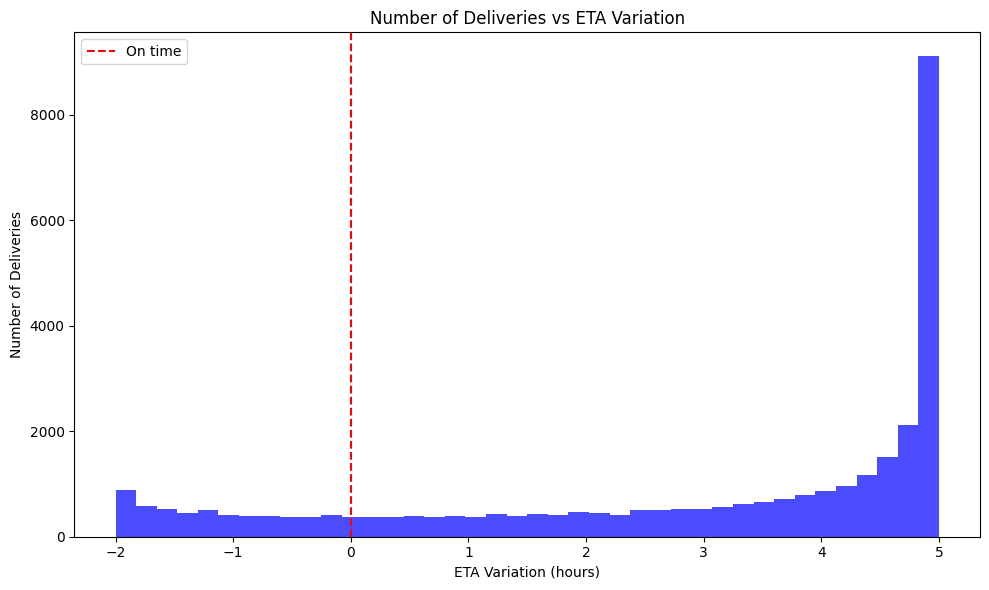

In [23]:
import matplotlib.pyplot as plt
# Convenience reference
routing_df = df[[
    "timestamp",
    "vehicle_gps_latitude", "vehicle_gps_longitude",
    "fuel_consumption_rate", "eta_variation_hours",
    "traffic_congestion_level", "weather_condition_severity",
    "route_risk_level", "delivery_time_deviation"
]].copy()
# Drop missing ETA values
eta_data = routing_df["eta_variation_hours"].dropna()

#  Histogram (counts of deliveries per ETA bin) 
plt.figure(figsize=(10,6))
plt.hist(eta_data, bins=40, color="blue", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="On time")
plt.title("Number of Deliveries vs ETA Variation")
plt.xlabel("ETA Variation (hours)")
plt.ylabel("Number of Deliveries")
plt.legend()
plt.tight_layout()
plt.show()




Fuel Consumption vs Congestion (regression)

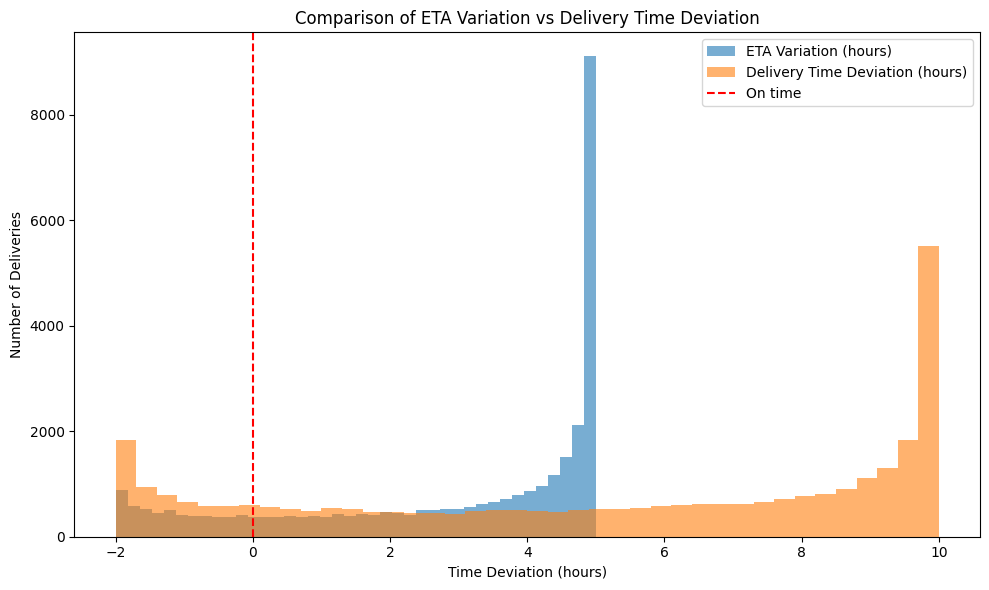

In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_csv("cleaned_data.csv")

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace(r"[()]", "", regex=True)
)
df = df.loc[:, ~df.columns.duplicated(keep="first")]
def fit_and_plot_lr(frame, xcol, ycol, title, xlabel, ylabel):
    # build from SAME filtered view
    d = frame[[xcol, ycol]].dropna().copy()
    if d.empty:
        print(f"[WARN] No data after dropna for {xcol} vs {ycol}")
        return
    X = d[[xcol]].to_numpy()         
    y = d[ycol].to_numpy()           

  
    assert len(X) == len(y), f"Length mismatch: X={len(X)} y={len(y)}"

    model = LinearRegression().fit(X, y)
    x_min, x_max = float(X.min()), float(X.max())
    x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1)
    y_pred = model.predict(x_range)
    plt.figure(figsize=(9,6))
    plt.scatter(X.ravel(), y, alpha=0.25, s=10, label="observations")
    plt.plot(x_range.ravel(), y_pred, linewidth=2.0, label="OLS fit")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

h = routing_df[["eta_variation_hours", "delivery_time_deviation"]].dropna()
plt.figure(figsize=(10,6))
plt.hist(h["eta_variation_hours"], bins=40, alpha=0.6, label="ETA Variation (hours)")
plt.hist(h["delivery_time_deviation"], bins=40, alpha=0.6, label="Delivery Time Deviation (hours)")
plt.axvline(0, color="red", linestyle="--", label="On time")
plt.title("Comparison of ETA Variation vs Delivery Time Deviation")
plt.xlabel("Time Deviation (hours)")
plt.ylabel("Number of Deliveries")
plt.legend()
plt.tight_layout()
plt.show()



c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


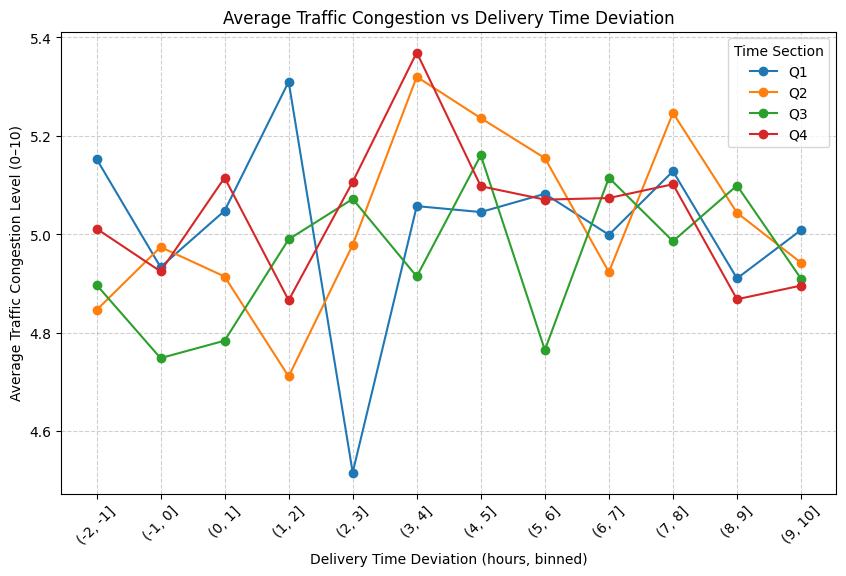

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop missing values
data = routing_df.dropna(subset=["timestamp","traffic_congestion_level","delivery_time_deviation"]).copy()

# Ensure timestamp is datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Split into 4 equal time sections
data["time_quartile"] = pd.qcut(data["timestamp"].rank(method="first"), q=4, labels=["Q1","Q2","Q3","Q4"])

# Bin delivery time deviation (e.g. into 1-hour bins)
data["deviation_bin"] = pd.cut(data["delivery_time_deviation"], bins=range(-2, 12, 1))  

# Compute average congestion per deviation bin per quartile
grouped = data.groupby(["time_quartile","deviation_bin"])["traffic_congestion_level"].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))

for q in grouped["time_quartile"].unique():
    subset = grouped[grouped["time_quartile"] == q]
    plt.plot(subset["deviation_bin"].astype(str), 
             subset["traffic_congestion_level"], 
             marker="o", linestyle="-", label=q)

plt.title("Average Traffic Congestion vs Delivery Time Deviation")
plt.xlabel("Delivery Time Deviation (hours, binned)")
plt.ylabel("Average Traffic Congestion Level (0–10)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Time Section")
plt.show()


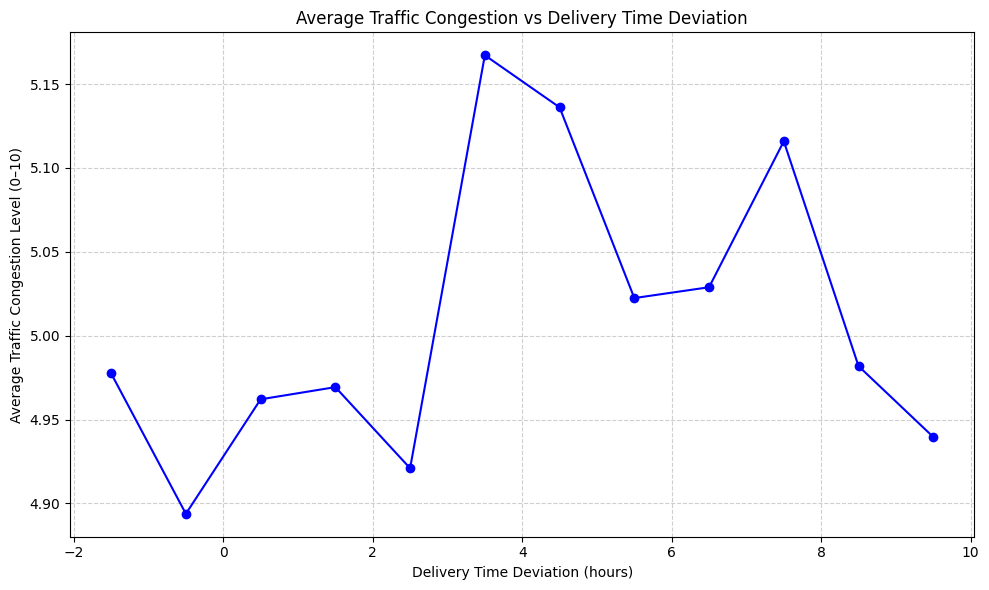

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop missing values
data = routing_df.dropna(subset=["delivery_time_deviation","traffic_congestion_level"]).copy()

# Bin delivery time deviation (1-hour bins)
data["deviation_bin"] = pd.cut(data["delivery_time_deviation"], bins=range(-2, 12, 1))

# Compute overall average congestion per deviation bin
grouped = data.groupby("deviation_bin")["traffic_congestion_level"].mean().reset_index()

# Use bin midpoints for cleaner x-axis
grouped["deviation_mid"] = grouped["deviation_bin"].apply(lambda x: x.mid)

# Plot single line
plt.figure(figsize=(10,6))
plt.plot(grouped["deviation_mid"], grouped["traffic_congestion_level"], marker="o", linestyle="-", color="blue")

plt.title("Average Traffic Congestion vs Delivery Time Deviation")
plt.xlabel("Delivery Time Deviation (hours)")
plt.ylabel("Average Traffic Congestion Level (0–10)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


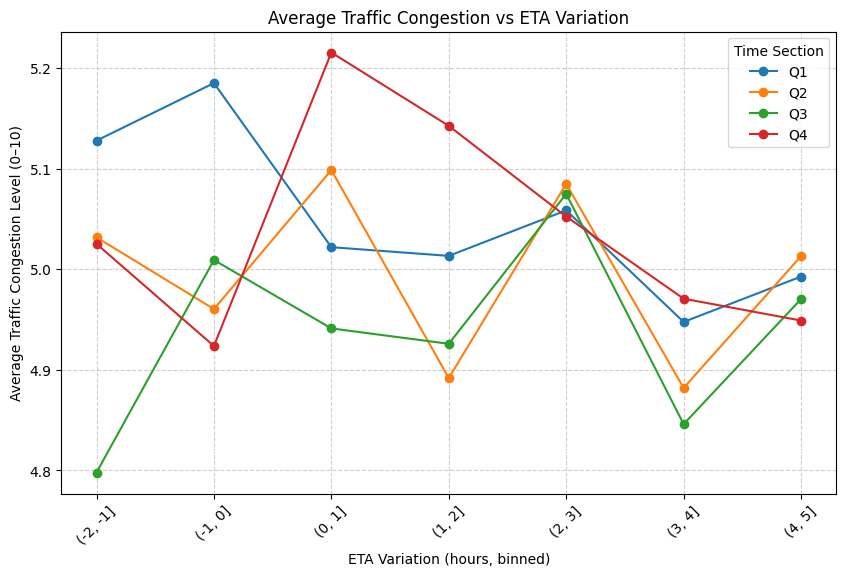

In [27]:
# Drop missing values
data = routing_df.dropna(subset=["timestamp","traffic_congestion_level","eta_variation_hours"]).copy()

# Ensure timestamp is datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Split into 4 equal time sections
data["time_quartile"] = pd.qcut(data["timestamp"].rank(method="first"), q=4, labels=["Q1","Q2","Q3","Q4"])

# Bin ETA variation 
data["eta_bin"] = pd.cut(data["eta_variation_hours"], bins=range(-2, 12, 1))

# Compute average congestion per ETA bin per quartile
grouped = data.groupby(["time_quartile","eta_bin"])["traffic_congestion_level"].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))

for q in grouped["time_quartile"].unique():
    subset = grouped[grouped["time_quartile"] == q]
    plt.plot(subset["eta_bin"].astype(str), 
             subset["traffic_congestion_level"], 
             marker="o", linestyle="-", label=q)

plt.title("Average Traffic Congestion vs ETA Variation")
plt.xlabel("ETA Variation (hours, binned)")
plt.ylabel("Average Traffic Congestion Level (0–10)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Time Section")
plt.show()


c:\Users\61434\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:537: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


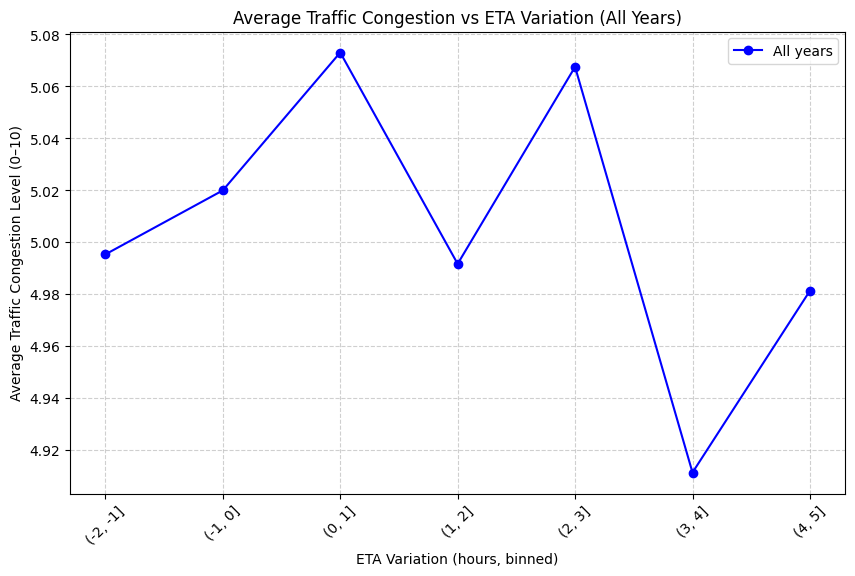

In [28]:
# Drop missing values
data = routing_df.dropna(subset=["eta_variation_hours","traffic_congestion_level"]).copy()

# Bin ETA variation (1-hour bins, adjust range if your data is wider)
data["eta_bin"] = pd.cut(data["eta_variation_hours"], bins=range(-2, 12, 1))

# Compute average congestion per ETA bin
grouped = data.groupby("eta_bin")["traffic_congestion_level"].mean().reset_index()

# Plot single line
plt.figure(figsize=(10,6))
plt.plot(grouped["eta_bin"].astype(str), 
         grouped["traffic_congestion_level"], 
         marker="o", linestyle="-", color="blue", label="All years")

plt.title("Average Traffic Congestion vs ETA Variation (All Years)")
plt.xlabel("ETA Variation (hours, binned)")
plt.ylabel("Average Traffic Congestion Level (0–10)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


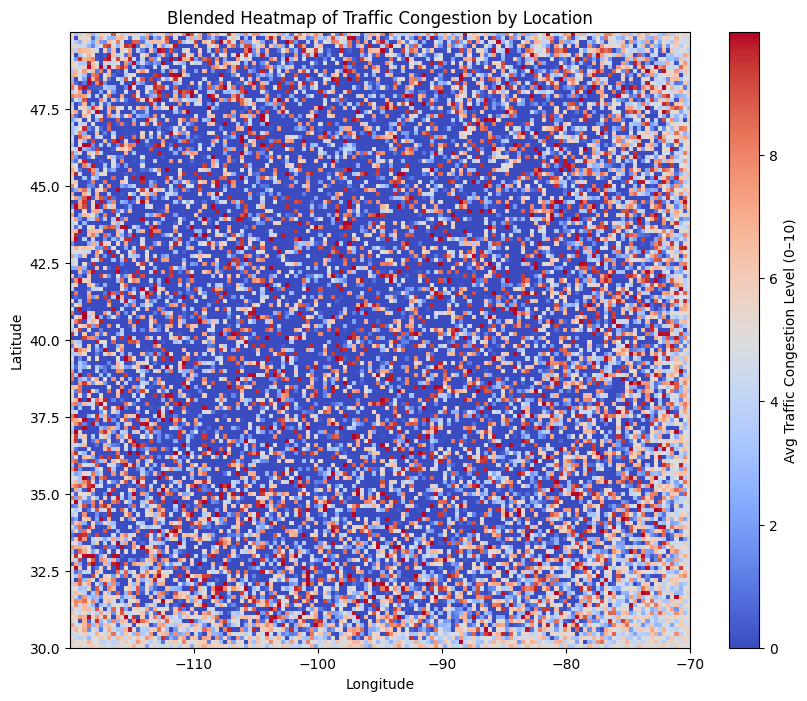

Using columns -> Lat: 'vehicle_gps_latitude', Lon: 'vehicle_gps_longitude', Traffic: 'traffic_congestion_level'


In [29]:
# Load
df = pd.read_csv("cleaned_data.csv")
BINS = (150, 150)   
CMAP = "coolwarm"
IM_INTERP = "bilinear" 



def norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r'[^a-z0-9]+', ' ', s)
    return re.sub(r'\s+', ' ', s).strip()

norm_map = {c: norm(c) for c in df.columns}
def find_col(tokens):
    for original, normalized in norm_map.items():
        if all(t in normalized for t in tokens):
            return original
    return None

lat_col = find_col(["latitude"])
lon_col = find_col(["longitude"])
traffic_col = find_col(["traffic","congestion"])

if not all([lat_col, lon_col, traffic_col]):
    print("Columns in file:", df.columns.tolist())
    raise KeyError("Could not auto-detect lat/lon/traffic columns.")

# Clean rows
g = df[[lat_col, lon_col, traffic_col]].dropna()
g = g[(g[lat_col].between(-90,90)) & (g[lon_col].between(-180,180))]

# Create 2D grid and compute average congestion
heatmap, xedges, yedges = np.histogram2d(
    g[lon_col], g[lat_col],
    bins=BINS, weights=g[traffic_col]
)
counts, _, _ = np.histogram2d(
    g[lon_col], g[lat_col],
    bins=BINS
)

# Avoid division by zero
avg_congestion = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts>0)

# Plot
plt.figure(figsize=(10,8))
plt.imshow(
    avg_congestion.T,
    origin="lower",
    cmap=CMAP,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="auto"
)
cb = plt.colorbar()
cb.set_label("Avg Traffic Congestion Level (0–10)")

plt.title("Blended Heatmap of Traffic Congestion by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()

print(f"Using columns -> Lat: '{lat_col}', Lon: '{lon_col}', Traffic: '{traffic_col}'")


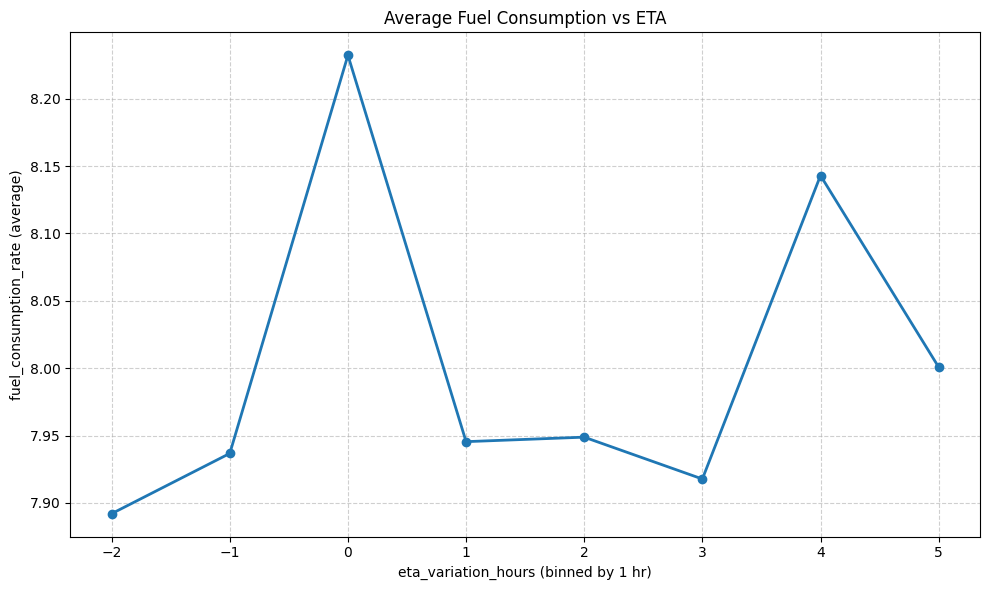

Using columns -> Fuel: 'fuel_consumption_rate', ETA: 'eta_variation_hours'. Points plotted: 8


In [30]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# config
BIN_WIDTH_HOURS = 1.0    

# helpers
def norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r'[^a-z0-9]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

norm_map = {c: norm(c) for c in df.columns}

def find_col(must_include):
    for original, normalized in norm_map.items():
        if all(tok in normalized for tok in must_include):
            return original
    return None

# detect columns
fuel_col = (find_col(["fuel","consumption","rate"])
            or find_col(["fuel","consumption"])
            or find_col(["fuel","rate"]))

eta_col = (find_col(["eta","variation"])
           or find_col(["delivery","time","deviation"])
           or find_col(["arrival","deviation"])
           or find_col(["eta"]))

if fuel_col is None or eta_col is None:
    print("Columns in the file:\n", df.columns.tolist())
    raise KeyError("Could not find Fuel Consumption and/or ETA columns. "
                   "Update detection logic with your exact names.")

plot_df = df[[fuel_col, eta_col]].dropna().copy()

# optional binning along ETA axis
if BIN_WIDTH_HOURS is not None and BIN_WIDTH_HOURS > 0:
    plot_df["_eta_bin"] = (
        np.round(plot_df[eta_col] / BIN_WIDTH_HOURS) * BIN_WIDTH_HOURS
    ).astype(float)
    grp = (plot_df.groupby("_eta_bin")[fuel_col]
                  .mean().reset_index(name="avg_fuel"))
    x = grp["_eta_bin"].values
    y = grp["avg_fuel"].values
    x_label = f"{eta_col} (binned by {BIN_WIDTH_HOURS:g} hr)"
else:
    grp = (plot_df.groupby(eta_col)[fuel_col]
                  .mean().reset_index(name="avg_fuel"))
    x = grp[eta_col].values
    y = grp["avg_fuel"].values
    x_label = eta_col

# sort for clean line
order = np.argsort(x)
x, y = x[order], y[order]

# plot
plt.figure(figsize=(10,6))
plt.plot(x, y, marker="o", linestyle="-", linewidth=2)
plt.title("Average Fuel Consumption vs ETA")
plt.xlabel(x_label)
plt.ylabel(f"{fuel_col} (average)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Using columns -> Fuel: '{fuel_col}', ETA: '{eta_col}'. Points plotted: {len(x)}")


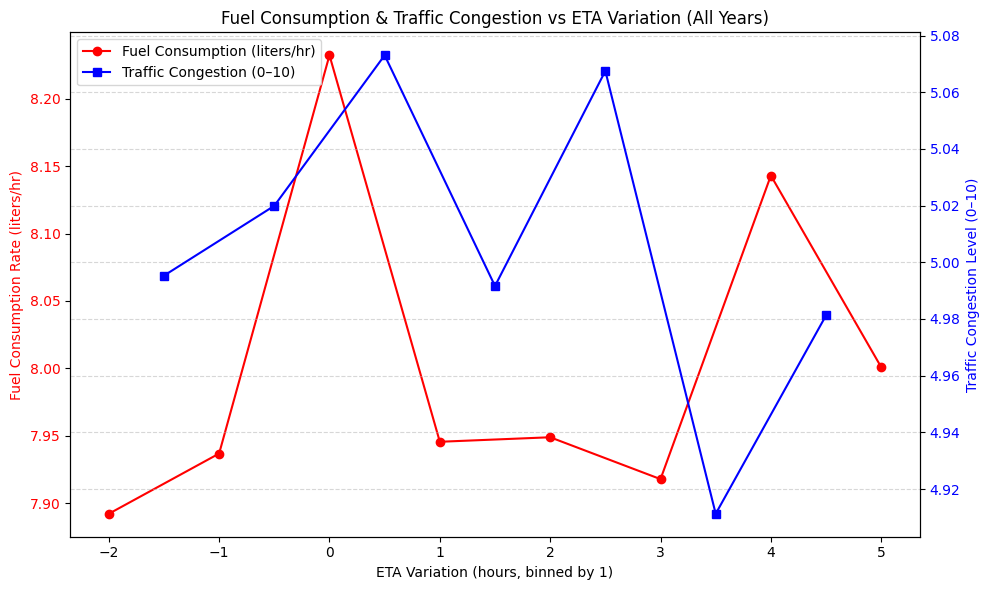

In [31]:
# Config: bin width for ETA axis (hours)
BIN_WIDTH_HOURS = 1.0   

# Fuel Consumption vs ETA 
fuel_data = routing_df.dropna(subset=["eta_variation_hours", "fuel_consumption_rate"]).copy()

if BIN_WIDTH_HOURS is not None and BIN_WIDTH_HOURS > 0:
    fuel_data["_eta_bin"] = (
        np.round(fuel_data["eta_variation_hours"] / BIN_WIDTH_HOURS) * BIN_WIDTH_HOURS
    ).astype(float)
    fuel_grouped = (fuel_data.groupby("_eta_bin")["fuel_consumption_rate"]
                    .mean().reset_index())
    fuel_x = fuel_grouped["_eta_bin"].values
    fuel_y = fuel_grouped["fuel_consumption_rate"].values
    x_label = f"ETA Variation (hours, binned by {BIN_WIDTH_HOURS:g})"
else:
    fuel_grouped = (fuel_data.groupby("eta_variation_hours")["fuel_consumption_rate"]
                    .mean().reset_index())
    fuel_x = fuel_grouped["eta_variation_hours"].values
    fuel_y = fuel_grouped["fuel_consumption_rate"].values
    x_label = "ETA Variation (hours)"

# Traffic Congestion vs ETA 
traffic_data = routing_df.dropna(subset=["eta_variation_hours", "traffic_congestion_level"]).copy()
traffic_data["eta_bin"] = pd.cut(traffic_data["eta_variation_hours"], bins=range(-2, 12, 1))
traffic_grouped = traffic_data.groupby("eta_bin")["traffic_congestion_level"].mean().reset_index()

# Use bin midpoints for cleaner x
traffic_grouped["bin_mid"] = traffic_grouped["eta_bin"].apply(lambda iv: (iv.left + iv.right)/2)
fig, ax1 = plt.subplots(figsize=(10,6))

# Left Y-axis (Fuel Consumption)
ax1.plot(fuel_x, fuel_y, marker="o", color="red", label="Fuel Consumption (liters/hr)")
ax1.set_ylabel("Fuel Consumption Rate (liters/hr)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Right Y-axis (Traffic Congestion)
ax2 = ax1.twinx()
ax2.plot(traffic_grouped["bin_mid"], traffic_grouped["traffic_congestion_level"],
         marker="s", color="blue", label="Traffic Congestion (0–10)")
ax2.set_ylabel("Traffic Congestion Level (0–10)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Shared X-axis
ax1.set_xlabel(x_label)
plt.title("Fuel Consumption & Traffic Congestion vs ETA Variation (All Years)")
plt.grid(True, linestyle="--", alpha=0.5)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


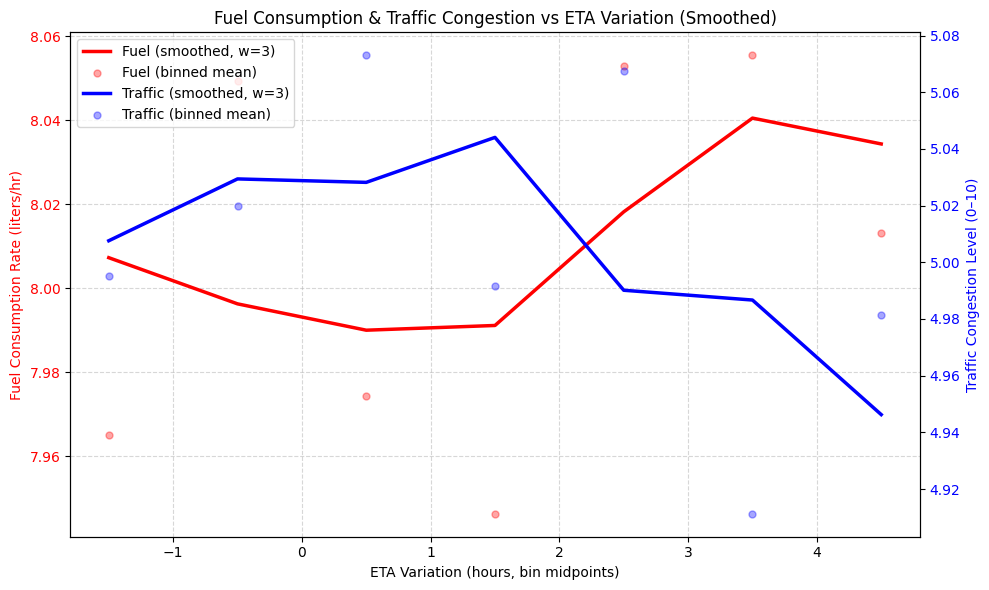

In [32]:
BIN_WIDTH_HOURS = 1.0    
ROLL_WINDOW     = 3       

req_eta = "eta_variation_hours"
fuel_data = routing_df.dropna(subset=[req_eta, "fuel_consumption_rate"]).copy()
traffic_data = routing_df.dropna(subset=[req_eta, "traffic_congestion_level"]).copy()

eta_min = math.floor(min(fuel_data[req_eta].min(), traffic_data[req_eta].min()))
eta_max = math.ceil(max(fuel_data[req_eta].max(), traffic_data[req_eta].max()))
if eta_max - eta_min < 4:
    eta_min -= 2
    eta_max += 2

BIN_EDGES = np.arange(eta_min, eta_max + BIN_WIDTH_HOURS, BIN_WIDTH_HOURS)

# Bin 
fuel_data["eta_bin"]    = pd.cut(fuel_data[req_eta],    bins=BIN_EDGES)
traffic_data["eta_bin"] = pd.cut(traffic_data[req_eta], bins=BIN_EDGES)

fuel_grouped = (
    fuel_data.groupby("eta_bin", observed=True)["fuel_consumption_rate"]
    .mean().reset_index()
)
traffic_grouped = (
    traffic_data.groupby("eta_bin", observed=True)["traffic_congestion_level"]
    .mean().reset_index()
)

# Bin midpoints for x axis
def interval_midpoint(iv: pd.Interval) -> float:
    return float(iv.left + (iv.right - iv.left) / 2)

fuel_grouped["eta_mid"]    = fuel_grouped["eta_bin"].apply(interval_midpoint)
traffic_grouped["eta_mid"] = traffic_grouped["eta_bin"].apply(interval_midpoint)

# smoothing
fuel_grouped   = fuel_grouped.sort_values("eta_mid").reset_index(drop=True)
traffic_grouped= traffic_grouped.sort_values("eta_mid").reset_index(drop=True)

fuel_grouped["fuel_smooth"] = (
    fuel_grouped["fuel_consumption_rate"].rolling(window=ROLL_WINDOW, center=True, min_periods=1).mean()
)
traffic_grouped["traffic_smooth"] = (
    traffic_grouped["traffic_congestion_level"].rolling(window=ROLL_WINDOW, center=True, min_periods=1).mean()
)

# Dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Fuel (left y)
ax1.plot(
    fuel_grouped["eta_mid"], fuel_grouped["fuel_smooth"],
    linewidth=2.5, marker=None, color="red", label=f"Fuel (smoothed, w={ROLL_WINDOW})"
)
ax1.scatter(
    fuel_grouped["eta_mid"], fuel_grouped["fuel_consumption_rate"],
    s=25, color="red", alpha=0.35, label="Fuel (binned mean)"
)
ax1.set_ylabel("Fuel Consumption Rate (liters/hr)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Traffic (right y)
ax2 = ax1.twinx()
ax2.plot(
    traffic_grouped["eta_mid"], traffic_grouped["traffic_smooth"],
    linewidth=2.5, marker=None, color="blue", label=f"Traffic (smoothed, w={ROLL_WINDOW})"
)
ax2.scatter(
    traffic_grouped["eta_mid"], traffic_grouped["traffic_congestion_level"],
    s=25, color="blue", alpha=0.35, label="Traffic (binned mean)"
)
ax2.set_ylabel("Traffic Congestion Level (0–10)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Shared x
ax1.set_xlabel("ETA Variation (hours, bin midpoints)")
ax1.set_title("Fuel Consumption & Traffic Congestion vs ETA Variation (Smoothed)")
ax1.grid(True, linestyle="--", alpha=0.5)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


Classification accuracy: 0.31217838765008576
               precision    recall  f1-score   support

    High Risk       0.73      0.31      0.44      4789
     Low Risk       0.09      0.36      0.15       622
Moderate Risk       0.15      0.28      0.19      1002

     accuracy                           0.31      6413
    macro avg       0.32      0.32      0.26      6413
 weighted avg       0.58      0.31      0.37      6413



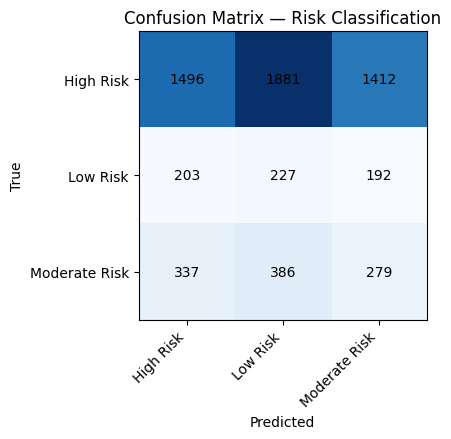

Regression  MAE=3.71h  RMSE=4.16h  R^2=-0.004


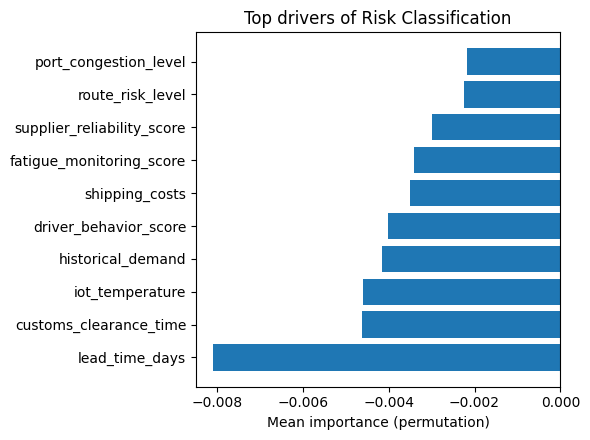

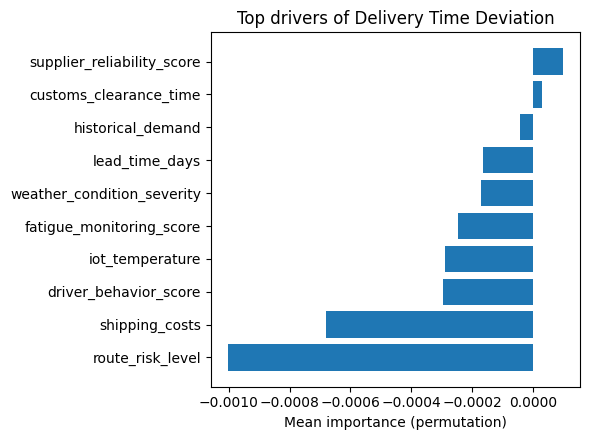

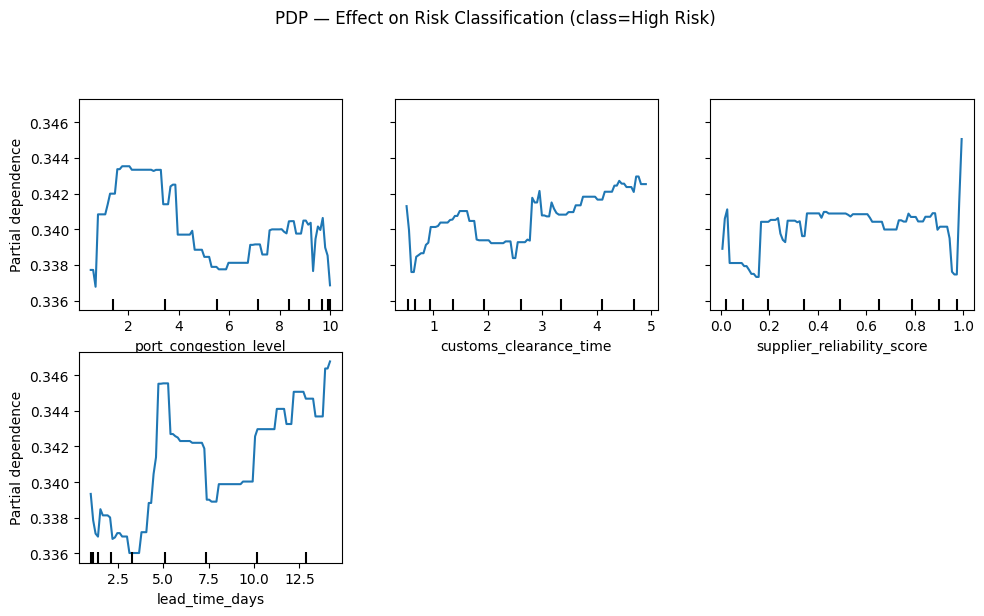

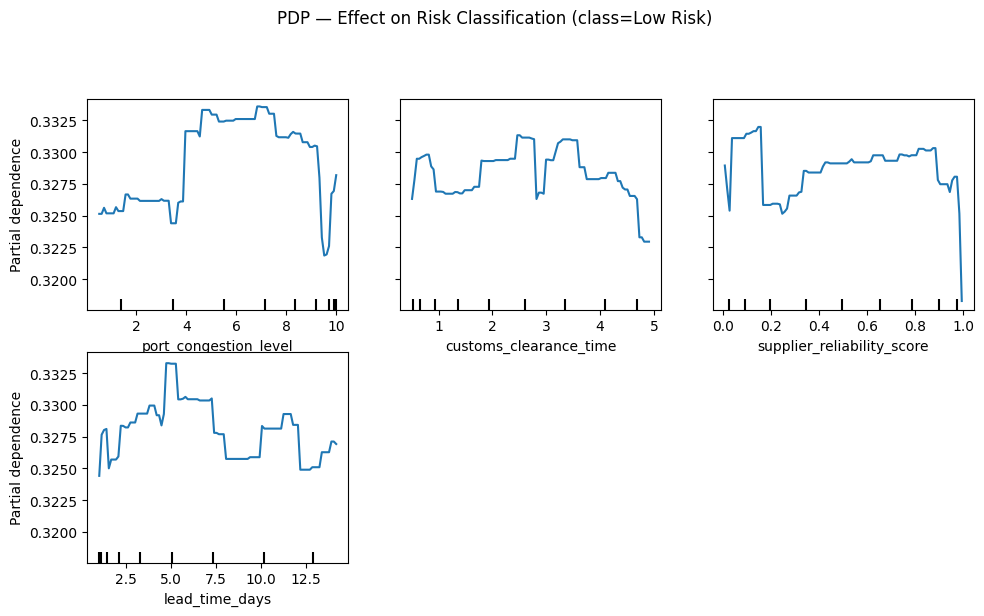

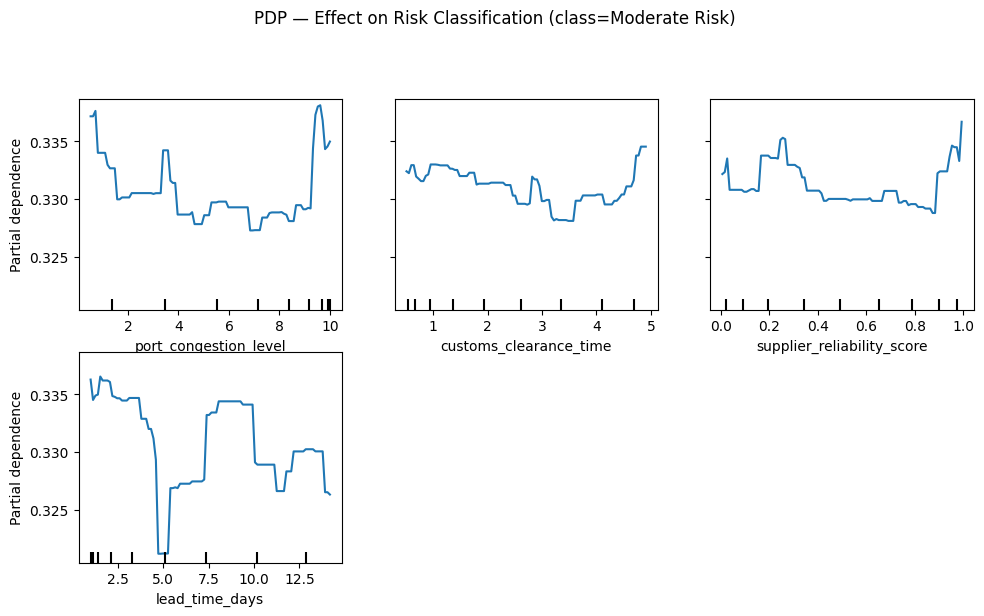

C:\Users\61434\AppData\Local\Temp\ipykernel_44372\1281934362.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


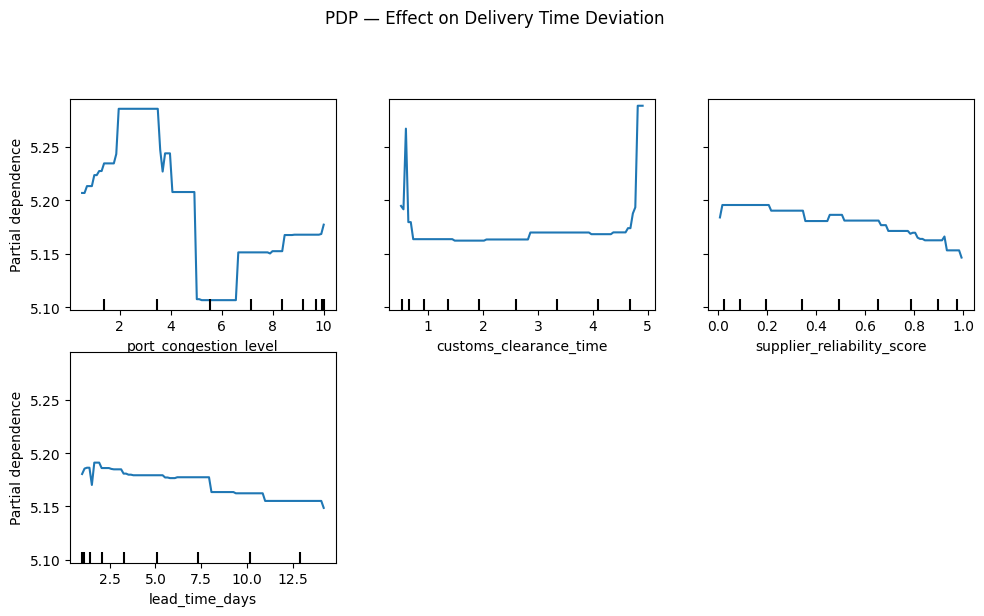

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Load 
df = pd.read_csv("data.csv")

#  Features/targets 
feat_cols = [
    "weather_condition_severity",
    "port_congestion_level",
    "shipping_costs",
    "supplier_reliability_score",
    "lead_time_days",
    "historical_demand",
    "iot_temperature",
    "cargo_condition_status",
    "route_risk_level",
    "customs_clearance_time",
    "driver_behavior_score",
    "fatigue_monitoring_score",
]
X = df[feat_cols].copy()

y_cls = df["risk_classification"]          
y_reg = df["delivery_time_deviation"]      

# Train/test split
Xtr, Xte, ytr_c, yte_c = train_test_split(X, y_cls, test_size=0.2, random_state=42, stratify=y_cls)
_,   _,  ytr_r, yte_r  = train_test_split(X, y_reg, test_size=0.2, random_state=42)

    # Preprocess
pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), feat_cols)], remainder="drop")

    # Models
clf = HistGradientBoostingClassifier(max_depth=6, class_weight="balanced", random_state=42)
reg = HistGradientBoostingRegressor(max_depth=6, random_state=42)

pipe_c = Pipeline([("pre", pre), ("model", clf)])
pipe_r = Pipeline([("pre", pre), ("model", reg)])

  #  Fit 
pipe_c.fit(Xtr, ytr_c)
pipe_r.fit(Xtr, ytr_r)

 #  Classification metrics + Confusion Matrix
pred_c = pipe_c.predict(Xte)
print("Classification accuracy:", accuracy_score(yte_c, pred_c))
print(classification_report(yte_c, pred_c))

labels = sorted(y_cls.unique())
cm = confusion_matrix(yte_c, pred_c, labels=labels)

plt.figure(figsize=(5.5,4.5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Risk Classification")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.tight_layout()
plt.show()

    #  Regression metrics 
pred_r = pipe_r.predict(Xte)
mae = mean_absolute_error(yte_r, pred_r)
mse = mean_squared_error(yte_r, pred_r)
rmse = np.sqrt(mse)
r2   = r2_score(yte_r, pred_r)
print(f"Regression  MAE={mae:.2f}h  RMSE={rmse:.2f}h  R^2={r2:.3f}")

    #  Permutation importances 
def plot_perm_importance(pipe, Xval, yval, title, n=10):
    result = permutation_importance(pipe, Xval, yval, n_repeats=8, random_state=7, n_jobs=-1)
    imp = pd.Series(result.importances_mean, index=feat_cols).sort_values(ascending=False).head(n)
    imp = imp[::-1]
    plt.figure(figsize=(6,4.5))
    plt.barh(imp.index, imp.values)
    plt.title(title)
    plt.xlabel("Mean importance (permutation)")
    plt.tight_layout()
    plt.show()

plot_perm_importance(pipe_c, Xte, yte_c, "Top drivers of Risk Classification")
plot_perm_importance(pipe_r, Xte, yte_r, "Top drivers of Delivery Time Deviation")

#  Partial Dependence Plots 
act_feats = ["port_congestion_level", "customs_clearance_time",
             "supplier_reliability_score", "lead_time_days"]

# For classifier: one pdp per class
for cls in pipe_c.classes_:
    fig, ax = plt.subplots(figsize=(10,6))
    PartialDependenceDisplay.from_estimator(
        pipe_c, Xte, act_feats, kind="average", ax=ax, target=cls
    )
    plt.suptitle(f"PDP — Effect on Risk Classification (class={cls})", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# For regressor: single pdp
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(pipe_r, Xte, act_feats, kind="average", ax=ax)
plt.suptitle("PDP — Effect on Delivery Time Deviation", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


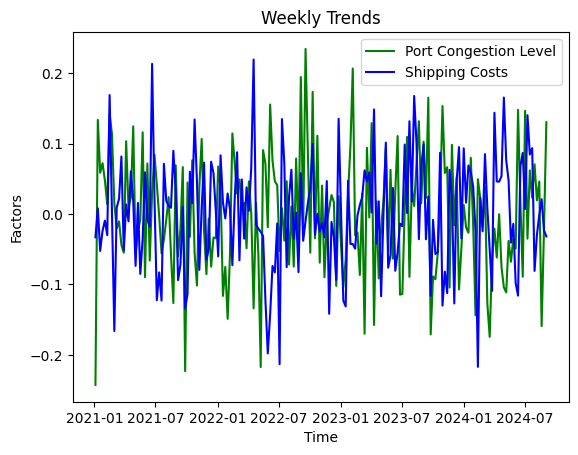

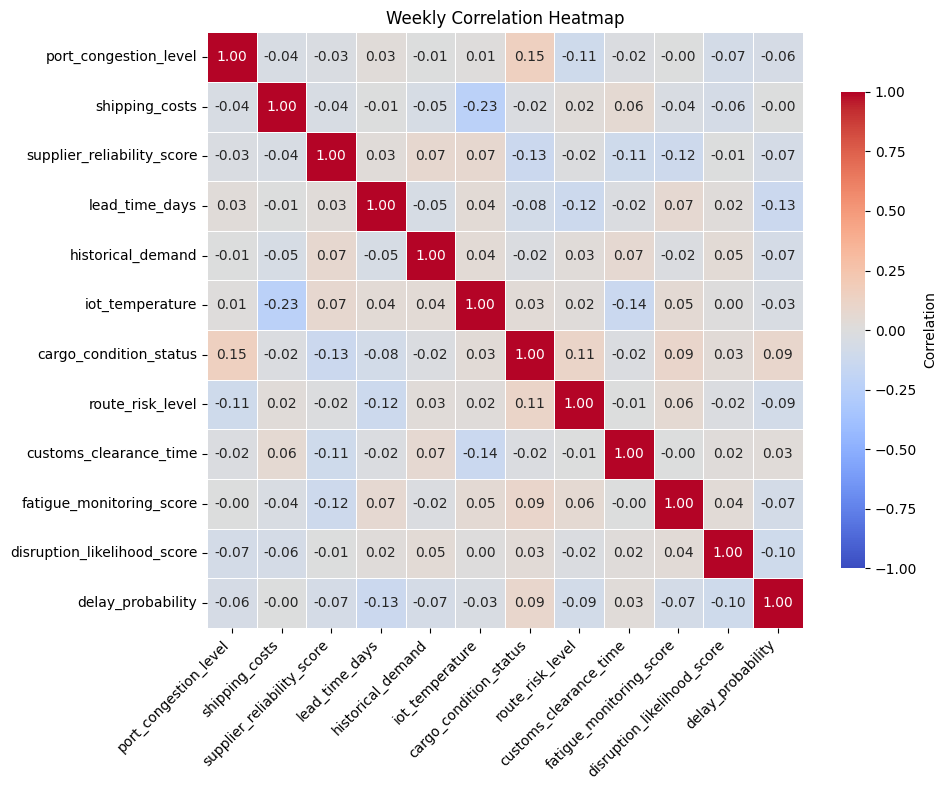

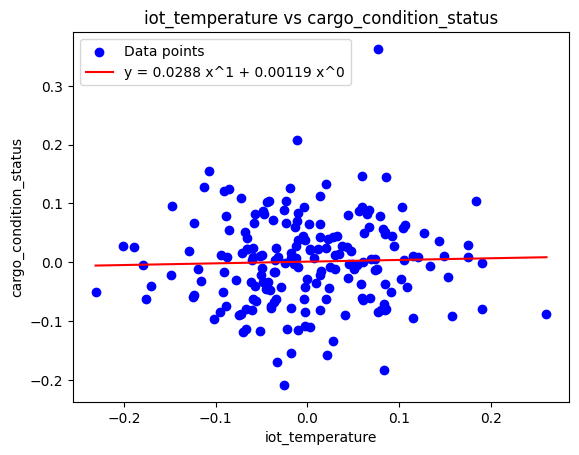

[0.02881852 0.00119183]


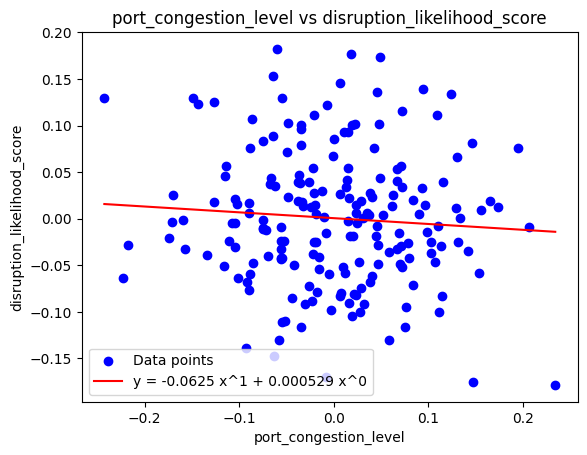

[-0.06248315  0.00052917]


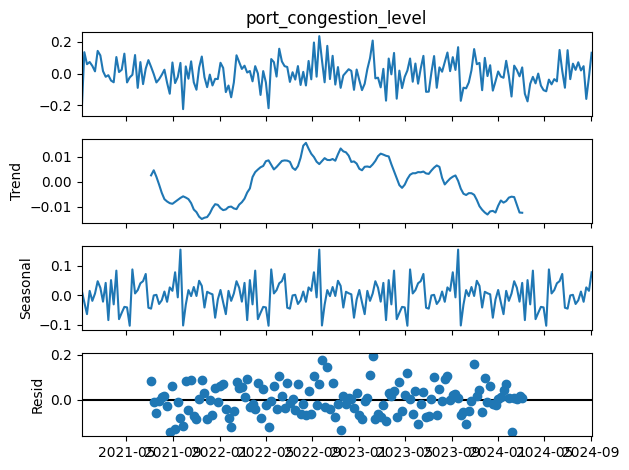

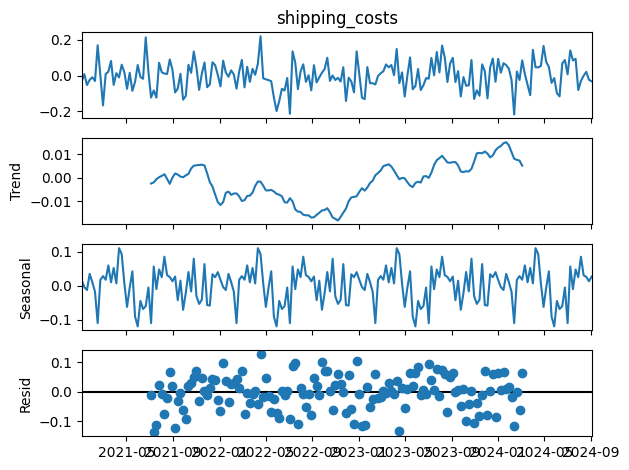

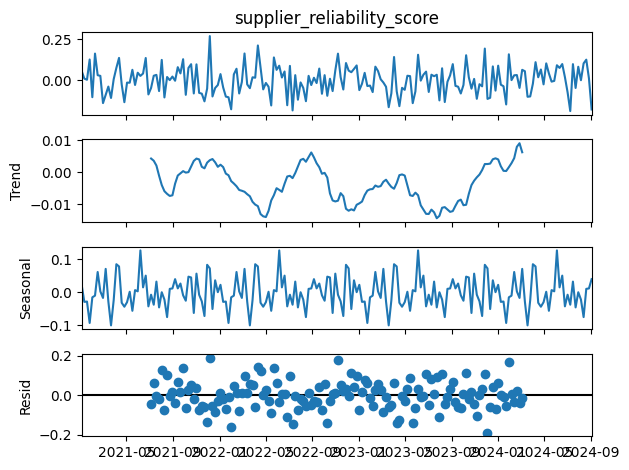

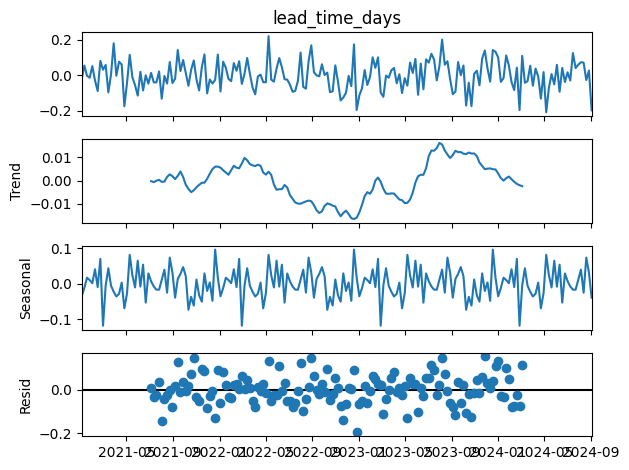

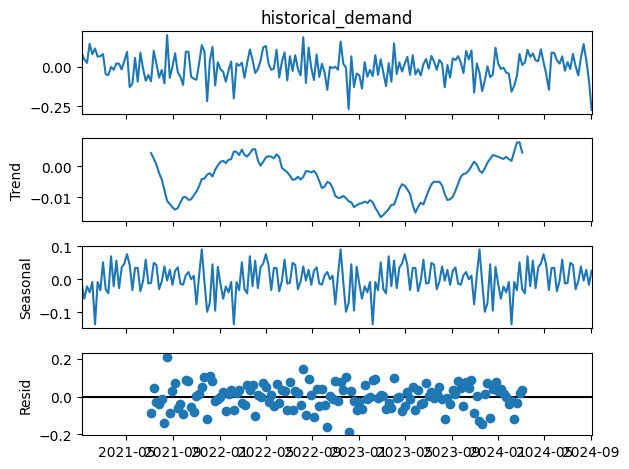

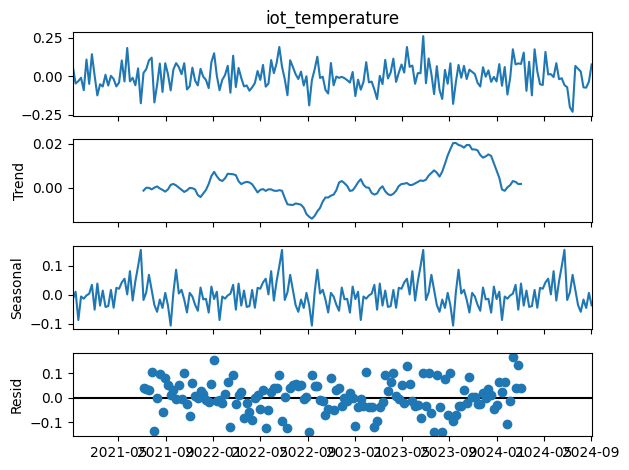

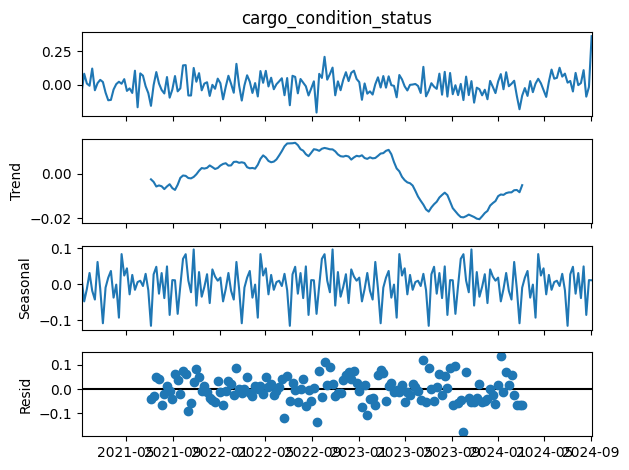

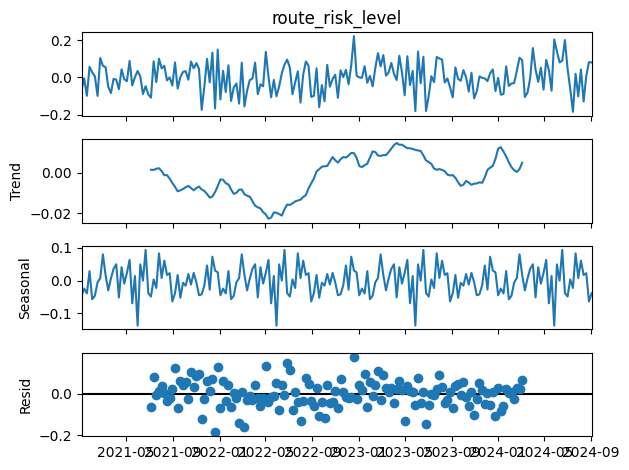

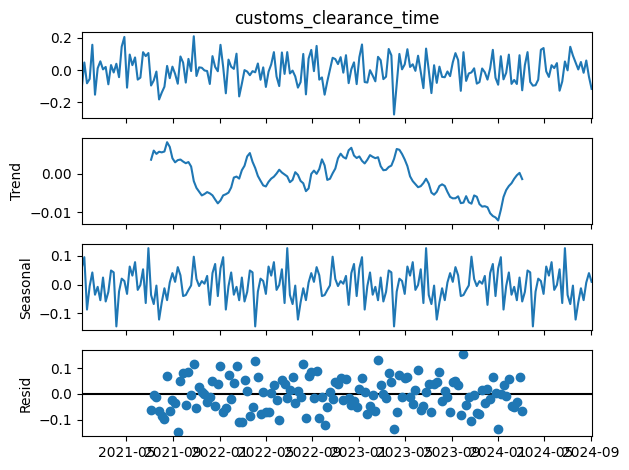

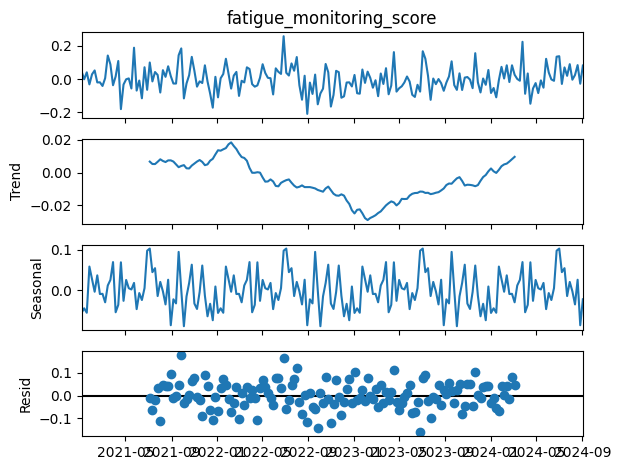

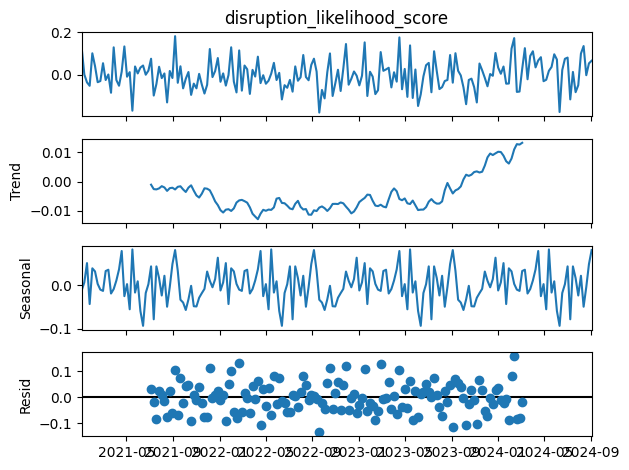

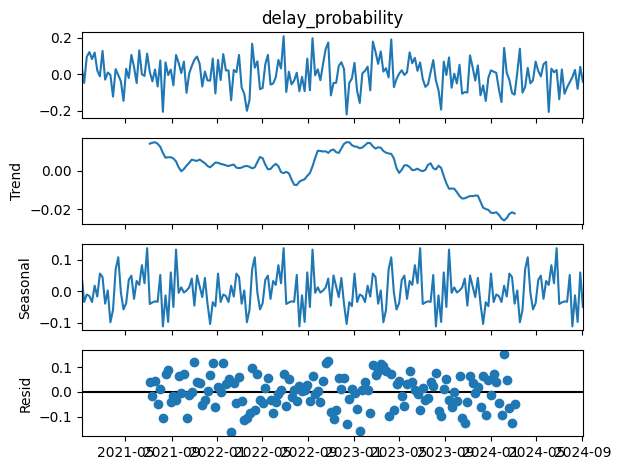

port_congestion_level: ADF Statistic=-8.690016642558284, p-value=4.0644886841045577e-14
shipping_costs: ADF Statistic=-12.422450976839832, p-value=4.1081716515729167e-23
supplier_reliability_score: ADF Statistic=-14.710596417426963, p-value=2.85159308478387e-27
lead_time_days: ADF Statistic=-13.2159871352302, p-value=1.024264338590769e-24
historical_demand: ADF Statistic=-13.827139187721324, p-value=7.712083808083143e-26
iot_temperature: ADF Statistic=-14.211286075930756, p-value=1.7197663342842163e-26
cargo_condition_status: ADF Statistic=-13.872778157529478, p-value=6.41927536190208e-26
route_risk_level: ADF Statistic=-8.561146126931868, p-value=8.688606688703214e-14
customs_clearance_time: ADF Statistic=-11.245213045853651, p-value=1.766552636858703e-20
fatigue_monitoring_score: ADF Statistic=-13.416968387978253, p-value=4.26324474460684e-25
disruption_likelihood_score: ADF Statistic=-14.989236362711209, p-value=1.131788375980337e-27
delay_probability: ADF Statistic=-5.3138608909837

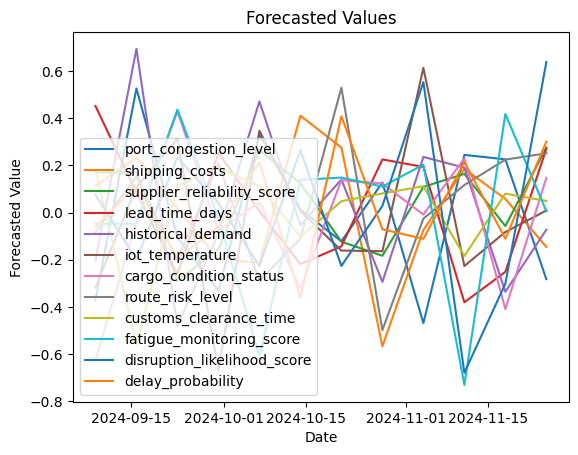

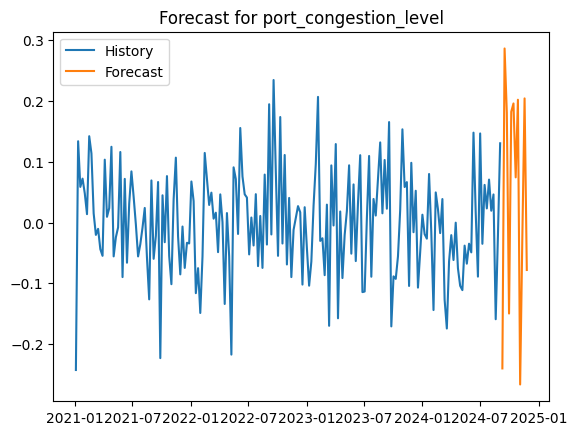

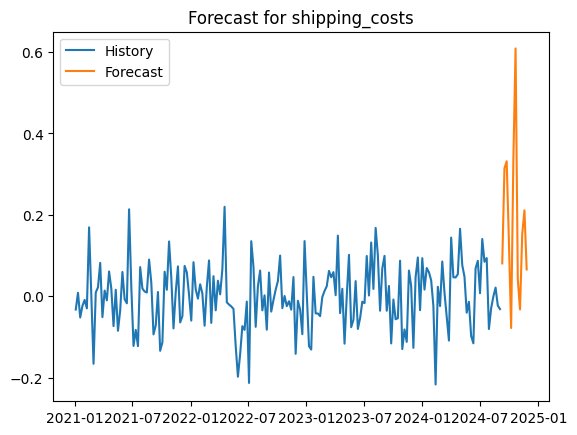

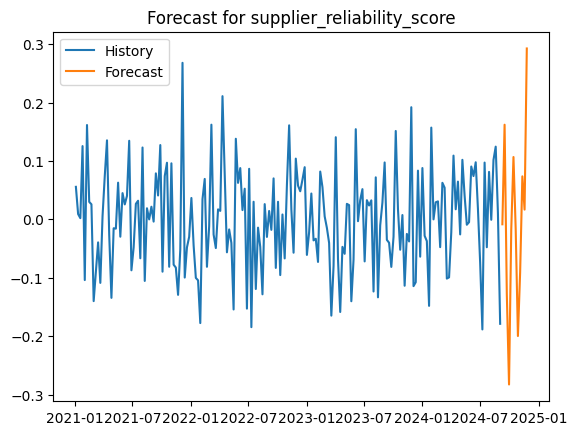

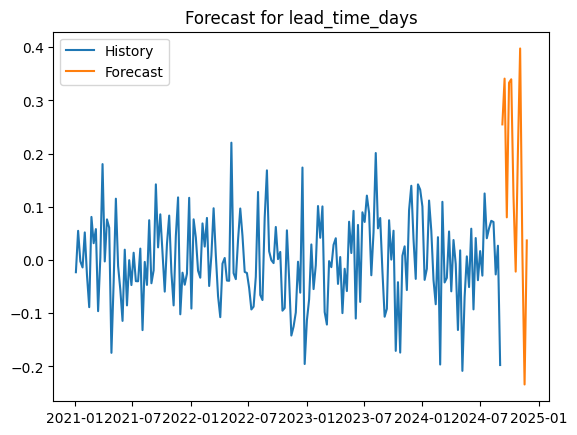

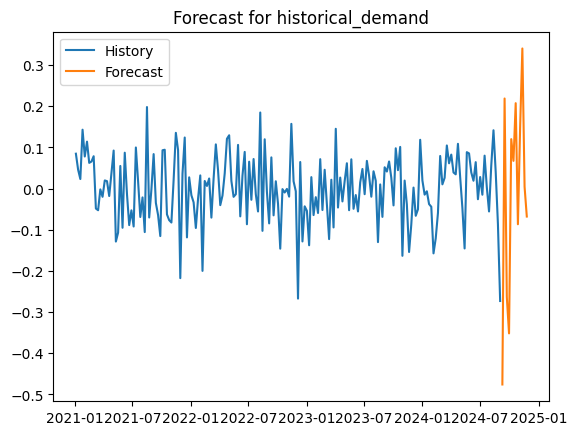

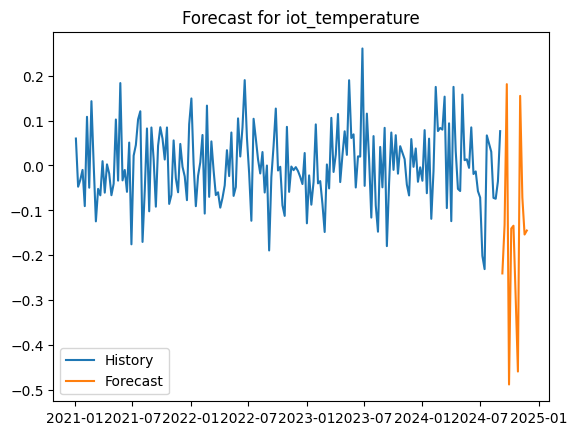

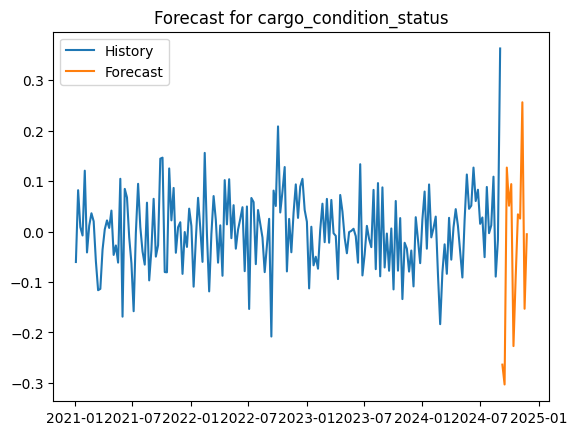

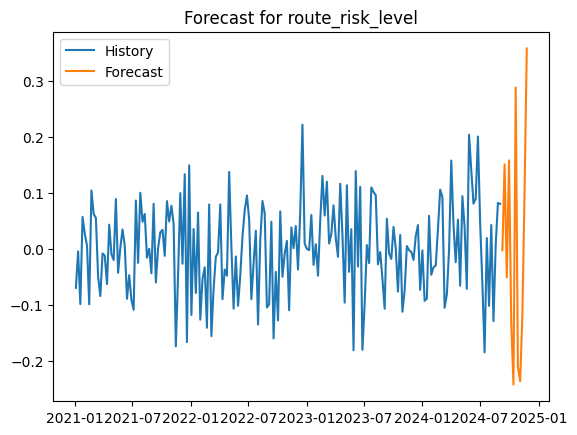

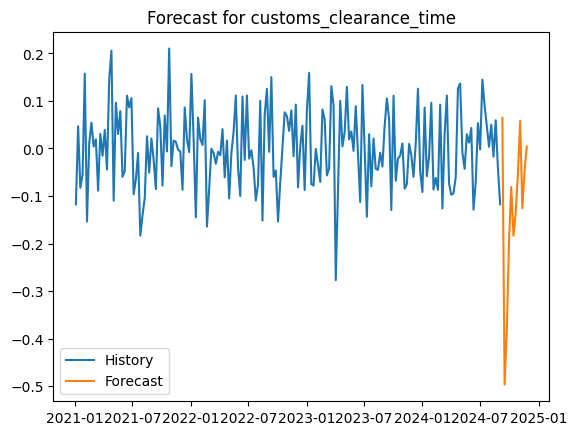

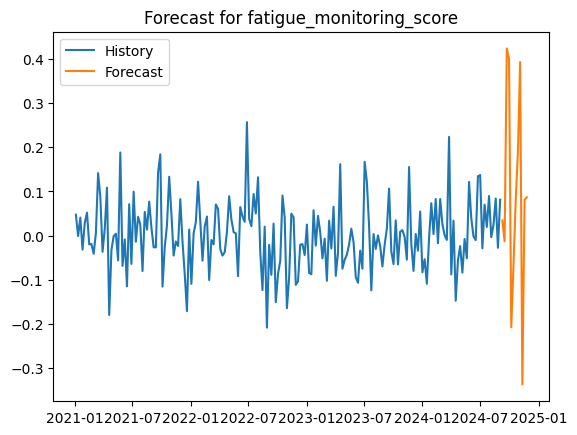

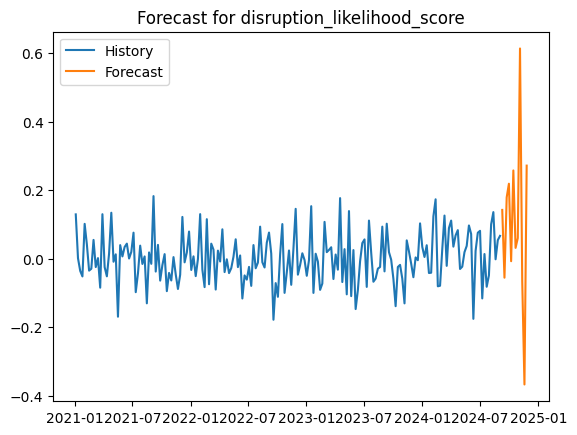

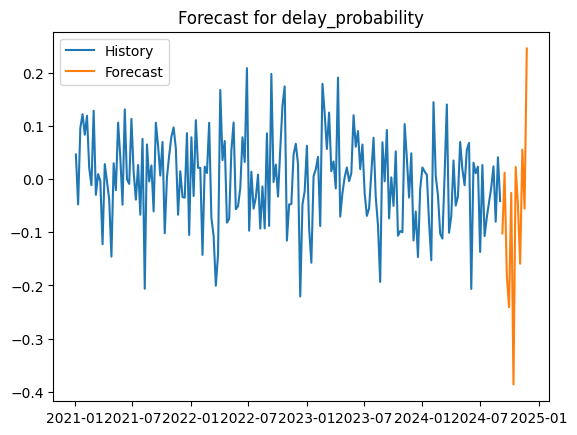

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('data.csv')

#******************************************* DATA EXTRACTION & CLEANING ********************************************************
part1 = df.iloc[:, 11:20]
part2 = df.iloc[:, 21:22]
part3 = df.iloc[:, 22:27]
df = pd.concat([df['timestamp'], part1, part2, part3], axis=1)


cols_to_drop = ['delivery_time_deviation', 'risk_classification']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])


df_clean = df.copy()
df_clean = df_clean.drop_duplicates(keep='first', ignore_index=True)
for col in df_clean.columns:
    if df_clean[col].dtype.kind in 'biufc': 
        med = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(med)
    else:
        df_clean[col] = df_clean[col].fillna('')

#Standardizing numeric features
numeric_cols = df_clean.select_dtypes(include=['number']).columns
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

#Convert 'timestamp' to datetime and set as index
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean.set_index('timestamp', inplace=True)

#Sample by week(starting on Monday)
df_weekly = df_clean.resample('W-MON').mean()

#******************************************* EXPLORATORY DATA ANALYSIS ********************************************************
plt.plot(df_weekly.index, df_weekly['port_congestion_level'], label='Port Congestion Level', color='green')
plt.plot(df_weekly.index, df_weekly['shipping_costs'], label='Shipping Costs', color='blue')
plt.xlabel('Time')
plt.ylabel('Factors')
plt.legend()
plt.title('Weekly Trends')
plt.show()

#Correlation matrix
corr = df_weekly.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title("Weekly Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Polynomial regression function
def poly_graph(t1, t2, degree=1):
    x = df_weekly[t1].values
    y = df_weekly[t2].values
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    x_line = np.linspace(np.min(x), np.max(x), 200)
    y_line = p(x_line)
    plt.scatter(x, y, color='blue', label='Data points')
    plt.plot(x_line, y_line, color='red', label=f'y = ' + ' + '.join([f'{coeffs[i]:.3g} x^{degree-i}' for i in range(len(coeffs))]))
    plt.xlabel(t1)
    plt.ylabel(t2)
    plt.legend()
    plt.title(f'{t1} vs {t2}')
    plt.show()
    return coeffs

print(poly_graph('iot_temperature', 'cargo_condition_status', 1))
print(poly_graph('port_congestion_level', 'disruption_likelihood_score', 1))

#decomposing the time series
def time_decomposition(t):
    series = df_weekly[t]
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=52)  # period=52 for weekly data
    decomposition.plot()
    plt.show()

for col in df_weekly.columns:
    time_decomposition(col)

#******************************************* DATA MODELLING ********************************************************

#look for stationarity
for col in df_weekly.columns:
    result = adfuller(df_weekly[col].dropna())
    print(f'{col}: ADF Statistic={result[0]}, p-value={result[1]}')

#handle non-stationary parts
df_weekly_diff = df_weekly.diff().dropna()

#find optimal lag length
model = VAR(df_weekly_diff)
lag_order = model.select_order().aic
print(f'Optimal Lag Length: {lag_order}')

#fit the Vector Auto Regression Model
model_fitted = model.fit(lag_order)

#predict values for the next 12 weeks
forecast_steps = 12
forecast = model_fitted.forecast(df_weekly_diff.values[-lag_order:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(df_weekly.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W-MON'), columns=df_weekly.columns)
print(forecast_df)

#inverse transform forecasts if differenced
forecast_cumsum = forecast_df.cumsum()
forecast_original = df_weekly.iloc[-1] + forecast_cumsum
print(forecast_original)

#visualise_forecasts
for col in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[col], label=col)

plt.title('Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()
plt.show()

#compare history and forecast
for col in df_weekly.columns:
    plt.figure()
    plt.plot(df_weekly.index, df_weekly[col], label="History")
    plt.plot(forecast_original.index, forecast_original[col], label="Forecast")
    plt.title(f"Forecast for {col}")
    plt.legend()
    plt.show()


(44, 12)
<bound method NDFrame.head of             port_congestion_level  shipping_costs  supplier_reliability_score  \
timestamp                                                                       
2021-01-31               0.040297       -0.021924                    0.016635   
2021-02-28               0.067087       -0.002042                    0.009097   
2021-03-31              -0.031117        0.011809                   -0.039167   
2021-04-30               0.071899        0.007952                    0.006874   
2021-05-31              -0.019867       -0.017776                    0.008780   
2021-06-30               0.046232        0.028516                    0.034260   
2021-07-31              -0.023108       -0.043712                    0.000418   
2021-08-31              -0.038736        0.047575                    0.001390   
2021-09-30              -0.040143       -0.081899                    0.054057   
2021-10-31              -0.013807        0.038121                    0

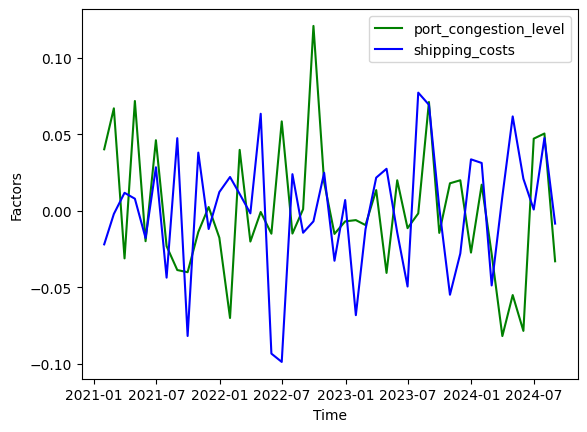

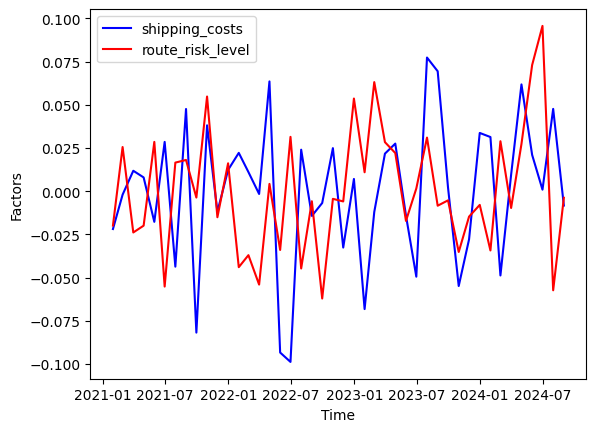

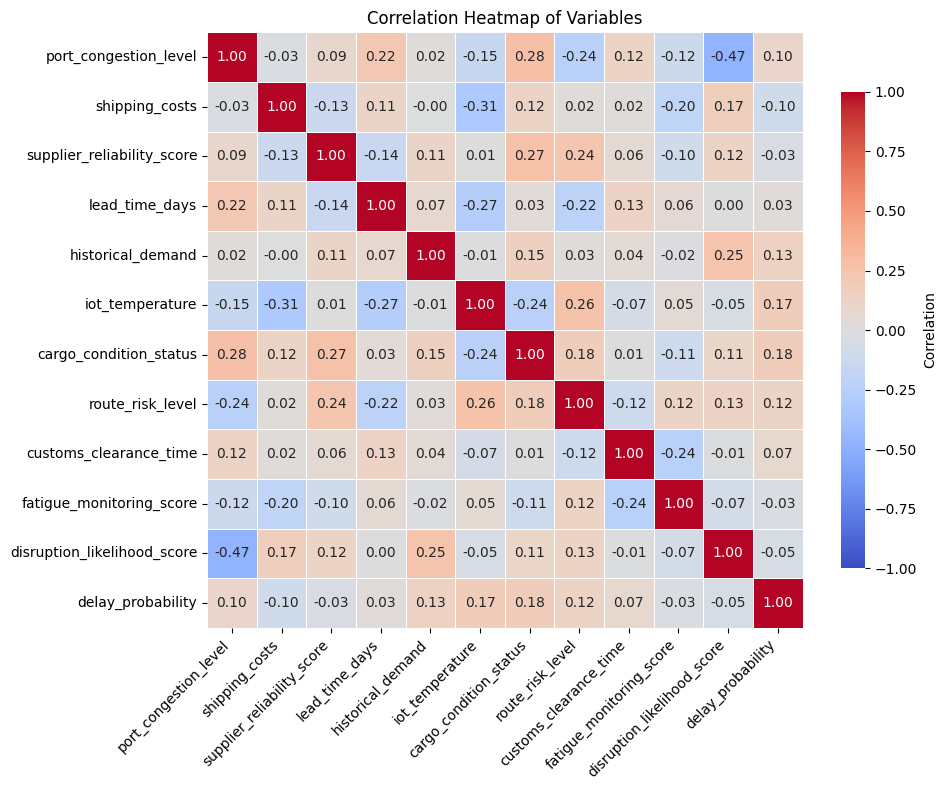

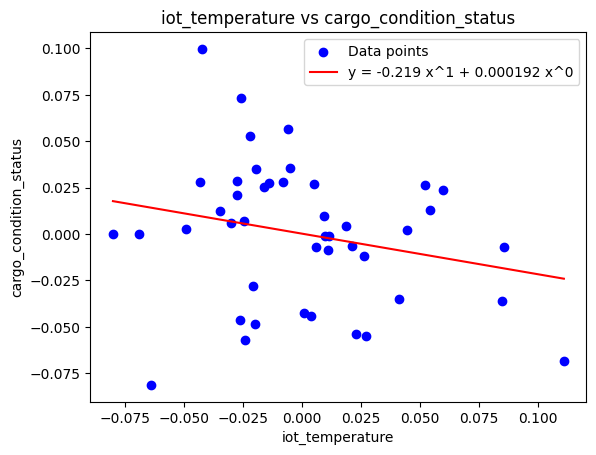

[-2.18955370e-01  1.92030434e-04]


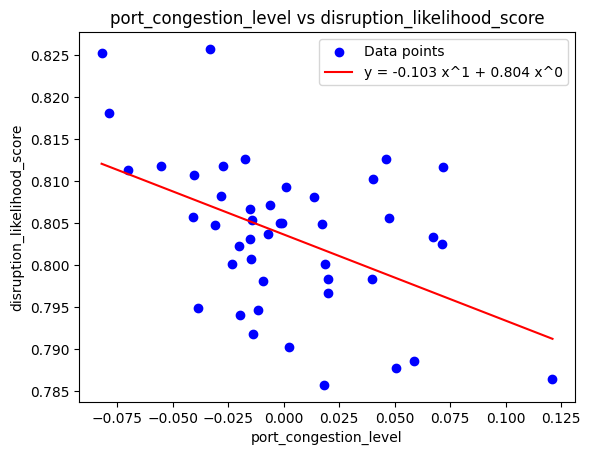

[-0.1026879   0.80369695]


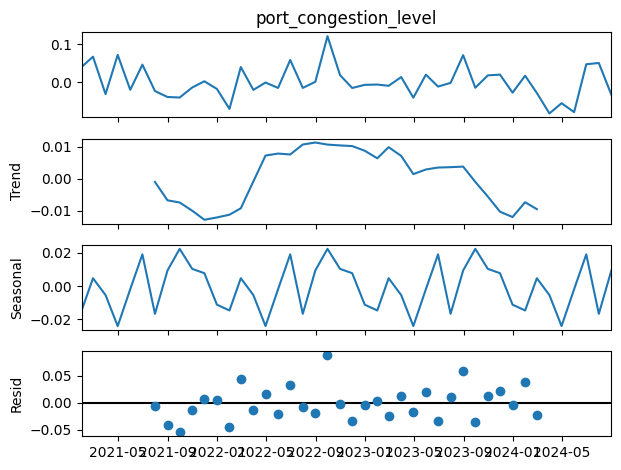

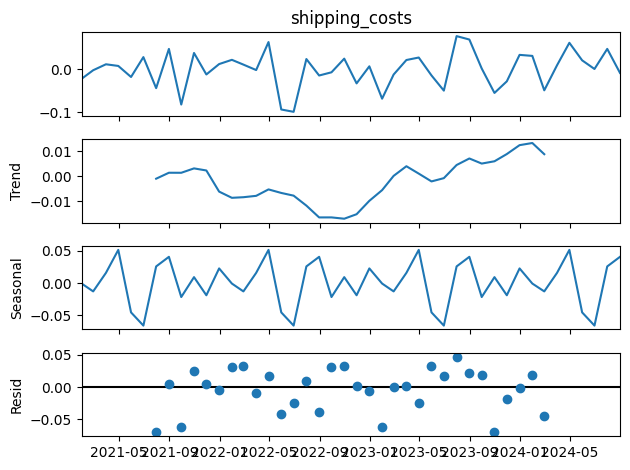

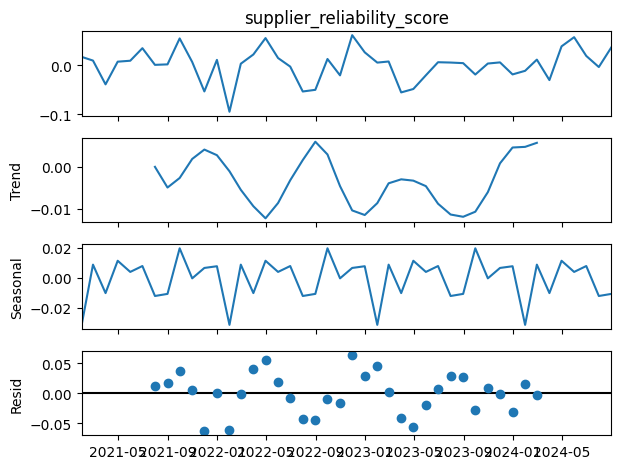

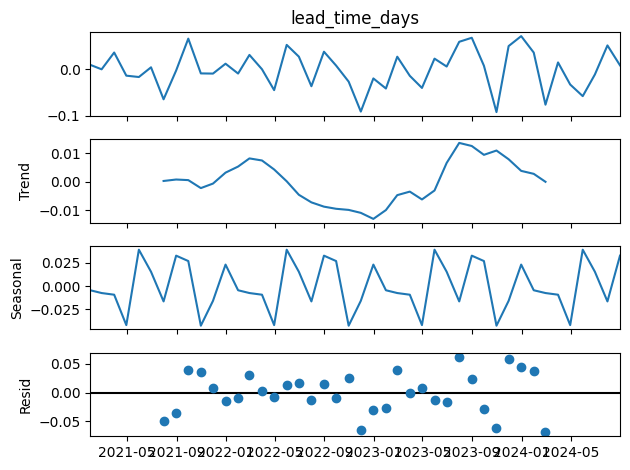

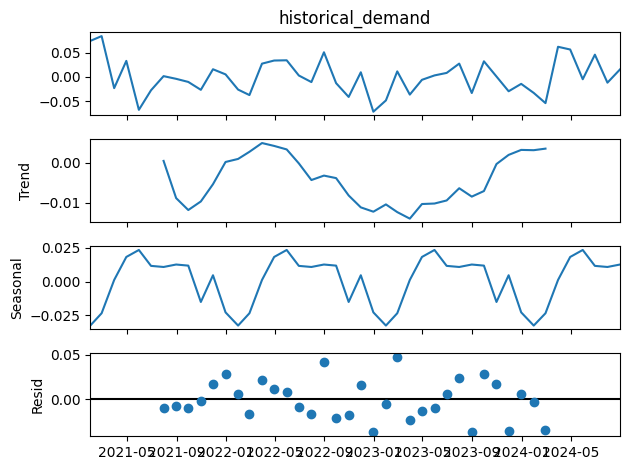

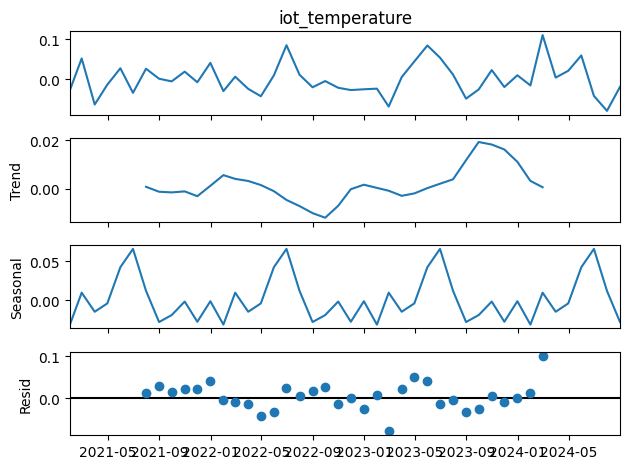

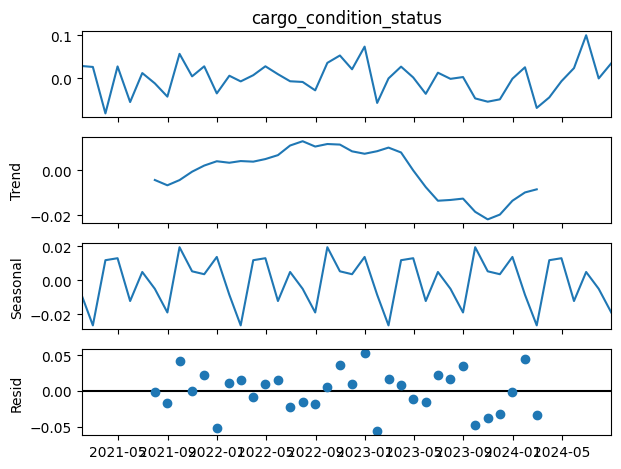

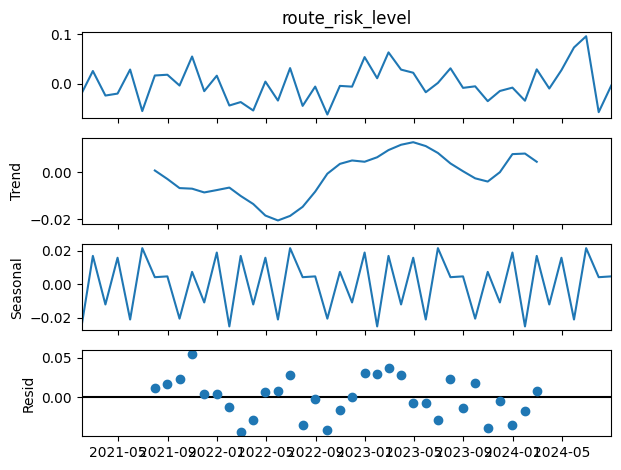

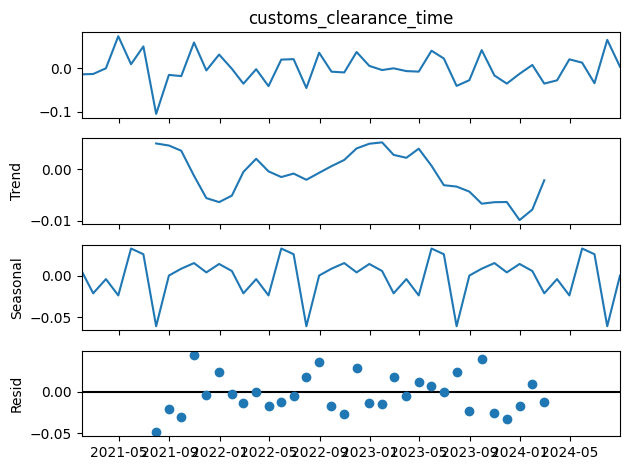

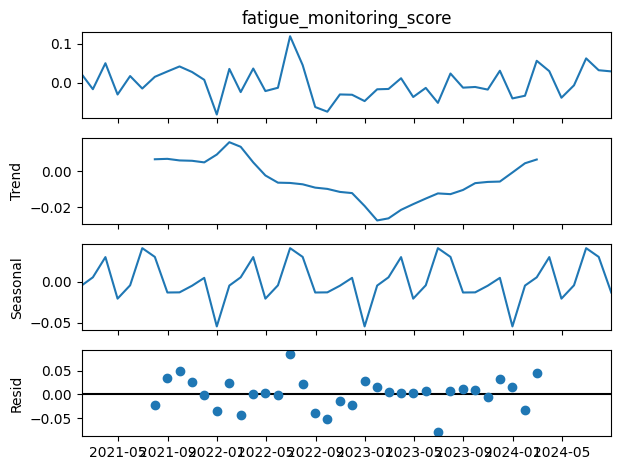

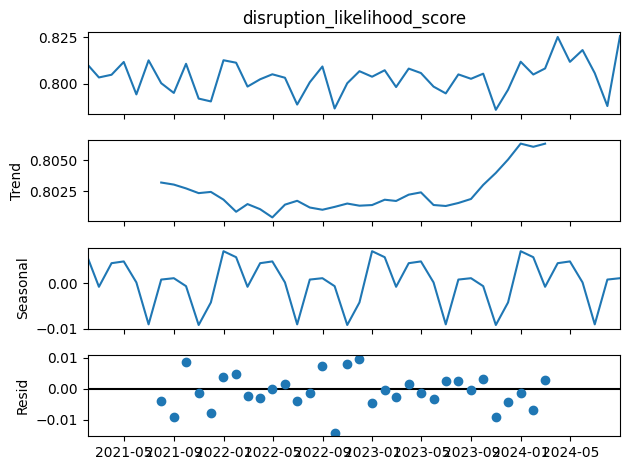

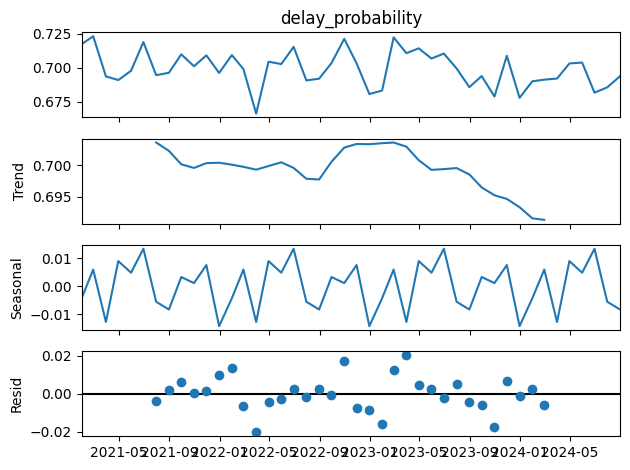

Index(['port_congestion_level', 'shipping_costs', 'supplier_reliability_score',
       'lead_time_days', 'historical_demand', 'iot_temperature',
       'cargo_condition_status', 'route_risk_level', 'customs_clearance_time',
       'fatigue_monitoring_score', 'disruption_likelihood_score',
       'delay_probability'],
      dtype='object')


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

df = pd.read_csv('data.csv')

#*************************************************** DATA EXTRACTION AND CLEANING ********************************************************

part1 = df.iloc[:, 11:20]
part2 = df.iloc[:, 21:22]
part3 = df.iloc[:, 22:27]

df = pd.concat([df['timestamp'], part1, part2, part3], axis=1)

cols_to_drop = ['delivery_time_deviation', 'risk_classification']
cols_existing = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_existing)

df_clean = df.copy()
df_clean = df_clean.drop_duplicates(keep='first', ignore_index=True)
for col in df_clean.columns:
    if df_clean[col].dtype.kind in 'biufc': 
        med = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(med)
    else:
        df_clean[col] = df_clean[col].fillna('') 


numeric_cols = df_clean.select_dtypes(include=['number']).columns
scaler = StandardScaler()
numeric_cols = numeric_cols[0:10]
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])


df_clean['timestamp'] = pd.to_datetime(df['timestamp'])
df_clean.set_index('timestamp', inplace=True)
df_monthly = df_clean.resample('M').mean()
print(df_monthly.shape)  
print(df_monthly.head)

#*************************************************** EXPLORATORY DATA ANALYSIS ********************************************************


plt.plot(df_monthly.index,df_monthly['port_congestion_level'],label='port_congestion_level',color='green')
plt.plot(df_monthly.index,df_monthly['shipping_costs'],label='shipping_costs',color='blue')
plt.xlabel('Time')
plt.ylabel('Factors')
plt.legend()
plt.show()
plt.close()

plt.plot(df_monthly.index,df_monthly['shipping_costs'],label='shipping_costs',color='blue')
plt.plot(df_monthly.index,df_monthly['route_risk_level'],label='route_risk_level',color='red')
plt.xlabel('Time')
plt.ylabel('Factors')
plt.legend()
plt.show()


#correlation matrix
corr = df_monthly.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm",vmin=-1, vmax=1, center=0,linewidths=0.5,square=True,cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title("Correlation Heatmap of Variables")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

def poly_graph(t1, t2, degree=1):
    x = df_monthly[t1].values
    y = df_monthly[t2].values
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    x_line = np.linspace(np.min(x), np.max(x), 200)
    y_line = p(x_line)
    plt.scatter(x, y, color='blue', label='Data points')
    plt.plot(x_line, y_line, color='red', label=f'y = ' + ' + '.join([f'{coeffs[i]:.3g} x^{degree-i}' for i in range(len(coeffs))]))
    plt.xlabel(t1)
    plt.ylabel(t2)
    plt.legend()
    plt.title(f'{t1} vs {t2}')
    plt.show()
    return coeffs


print(poly_graph('iot_temperature','cargo_condition_status',1))
print(poly_graph('port_congestion_level','disruption_likelihood_score',1))


def time_decomposition(t):
    series = df_monthly[t]
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=12) 
    decomposition.plot()
    plt.show()


for f in df.columns[1:]:time_decomposition(f)
print(df_monthly.columns)



